## Introduction

The task is to invent a rule to predict price behaviour in next two hour period. Ideally to indicate alerts (signals) for Long or Short positions opening.
My idea is to train a model to predict each candle whether it is a kline to buy, sell or hold your positions.
We can't use binance, because Russian accounts are not accepted to pass KYC, which is crucial for API key release. That is why we are using Bybit.
Ticker is BTCUSDT because it's understandable trade tool.

## Imports

In [ ]:
from pybit.unified_trading import HTTP
import talib
import backtrader as bt
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import seaborn as sns
import numpy as np
from catboost import CatBoostClassifier, cv, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.utils import resample
import pickle
from config import api_key, api_secret
# for bigger timeframes later: from statsmodels.tsa.seasonal import seasonal_decompose

## EDA

### Creating session, get data

In [ ]:
# create session
session = HTTP(
    testnet=False,
    api_key=api_key,
    api_secret=api_secret
)

# request params
symbol = "BTCUSDT"
interval = 1  # 1M klines
minutes_per_request = 1000 # klines per pack
num_requests = 200

# NOW time in ms
end_time = int(time.time() * 1000)

all_klines = []

for _ in range(num_requests):
    start_time = end_time - (minutes_per_request * interval * 60 * 1000) # define start_time

    response = session.get_kline(
        category="linear",  # linear for USDT perpetual
        symbol=symbol,
        interval=str(interval), # API requirement to convert into str
        start=start_time,
        end=end_time,
        limit=1000
    )
    if not response:
        break

    # append data to candle list
    all_klines.extend(response['result']['list'])

    # upd end_time for next iteration
    end_time = start_time

# create df from all_klines list
df = pd.DataFrame(all_klines, columns=[
    'timestamp', 'open', 'high', 'low', 'close', 'volume', 'turnover'
])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

/var/folders/xj/zp3s7j7n74g_6bbl_hn3xtx80000gn/T/ipykernel_60446/1148087570.py:43: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')


In [ ]:
df.head()

,open,high,low,close,volume,turnover
timestamp,,,,,,
2024-03-30 22:30:06.592,69821.1,69821.1,69815,69815,2.719,189833.5922
2024-03-30 22:30:06.592,69815,69815.1,69751.6,69751.6,20.465,1428179.2292
2024-03-30 22:32:17.664,69810.3,69862.9,69810.3,69851.7,116.894,8164222.0901
2024-03-30 22:32:17.664,69751.6,69824.1,69750.4,69810.3,132.743,9264577.971
2024-03-30 22:34:28.736,69825.5,69825.5,69771.6,69771.7,14.075,982515.862


In [ ]:
# see description features
df.describe()

,open,high,low,close,volume,turnover
count,200000,200000,200000,200000,200000,200000
unique,103159,98884,99183,103160,108294,200000
top,64250,64250,67800,64250,19.877,189833.5922
freq,28,49,56,28,15,1


### Basic types, duplicates, NaNs handling

In [ ]:
# check dtypes, seems like we are working with str
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200000 entries, 2024-03-30 22:30:06.592000 to 2024-08-16 19:48:30.336000
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   open      200000 non-null  object
 1   high      200000 non-null  object
 2   low       200000 non-null  object
 3   close     200000 non-null  object
 4   volume    200000 non-null  object
 5   turnover  200000 non-null  object
dtypes: object(6)
memory usage: 10.7+ MB


In [ ]:
# change it
for col in df.columns:
    df[col] = df[col].astype('float')

In [ ]:
df.dtypes

open        float64
high        float64
low         float64
close       float64
volume      float64
turnover    float64
dtype: object

In [ ]:
# describe one more time
df.describe()

,open,high,low,close,volume,turnover
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,2.000000e+05
mean,64339.873090,64366.102147,64313.356808,64339.822374,81.59116,5.167675e+06
std,4094.135423,4089.378659,4098.771553,4094.130349,170.02305,1.062288e+07
min,49382.100000,49811.400000,48914.100000,49382.100000,0.09200,5.913017e+03
25%,61294.075000,61322.875000,61266.825000,61294.000000,16.68700,1.080446e+06
50%,64598.000000,64630.000000,64567.100000,64598.000000,37.07300,2.381893e+06
75%,67582.700000,67609.000000,67557.000000,67582.400000,83.73525,5.336649e+06
max,72760.000000,72854.500000,72671.000000,72760.000000,9012.66000,4.812404e+08


In [ ]:
# turnover col is not clear
df['turnover'].describe().apply(lambda x: f'{x:0.2f}')

count       200000.00
mean       5167674.85
std       10622883.54
min           5913.02
25%        1080445.79
50%        2381892.54
75%        5336649.47
max      481240383.66
Name: turnover, dtype: object

In [ ]:
# i see that data looks correct from the first glance. Max and min prices are normal, as well as other features

In [ ]:
# check NaNs
df.isna().sum()

open        0
high        0
low         0
close       0
volume      0
turnover    0
dtype: int64

In [ ]:
# check duplicates
df.duplicated().sum()

0

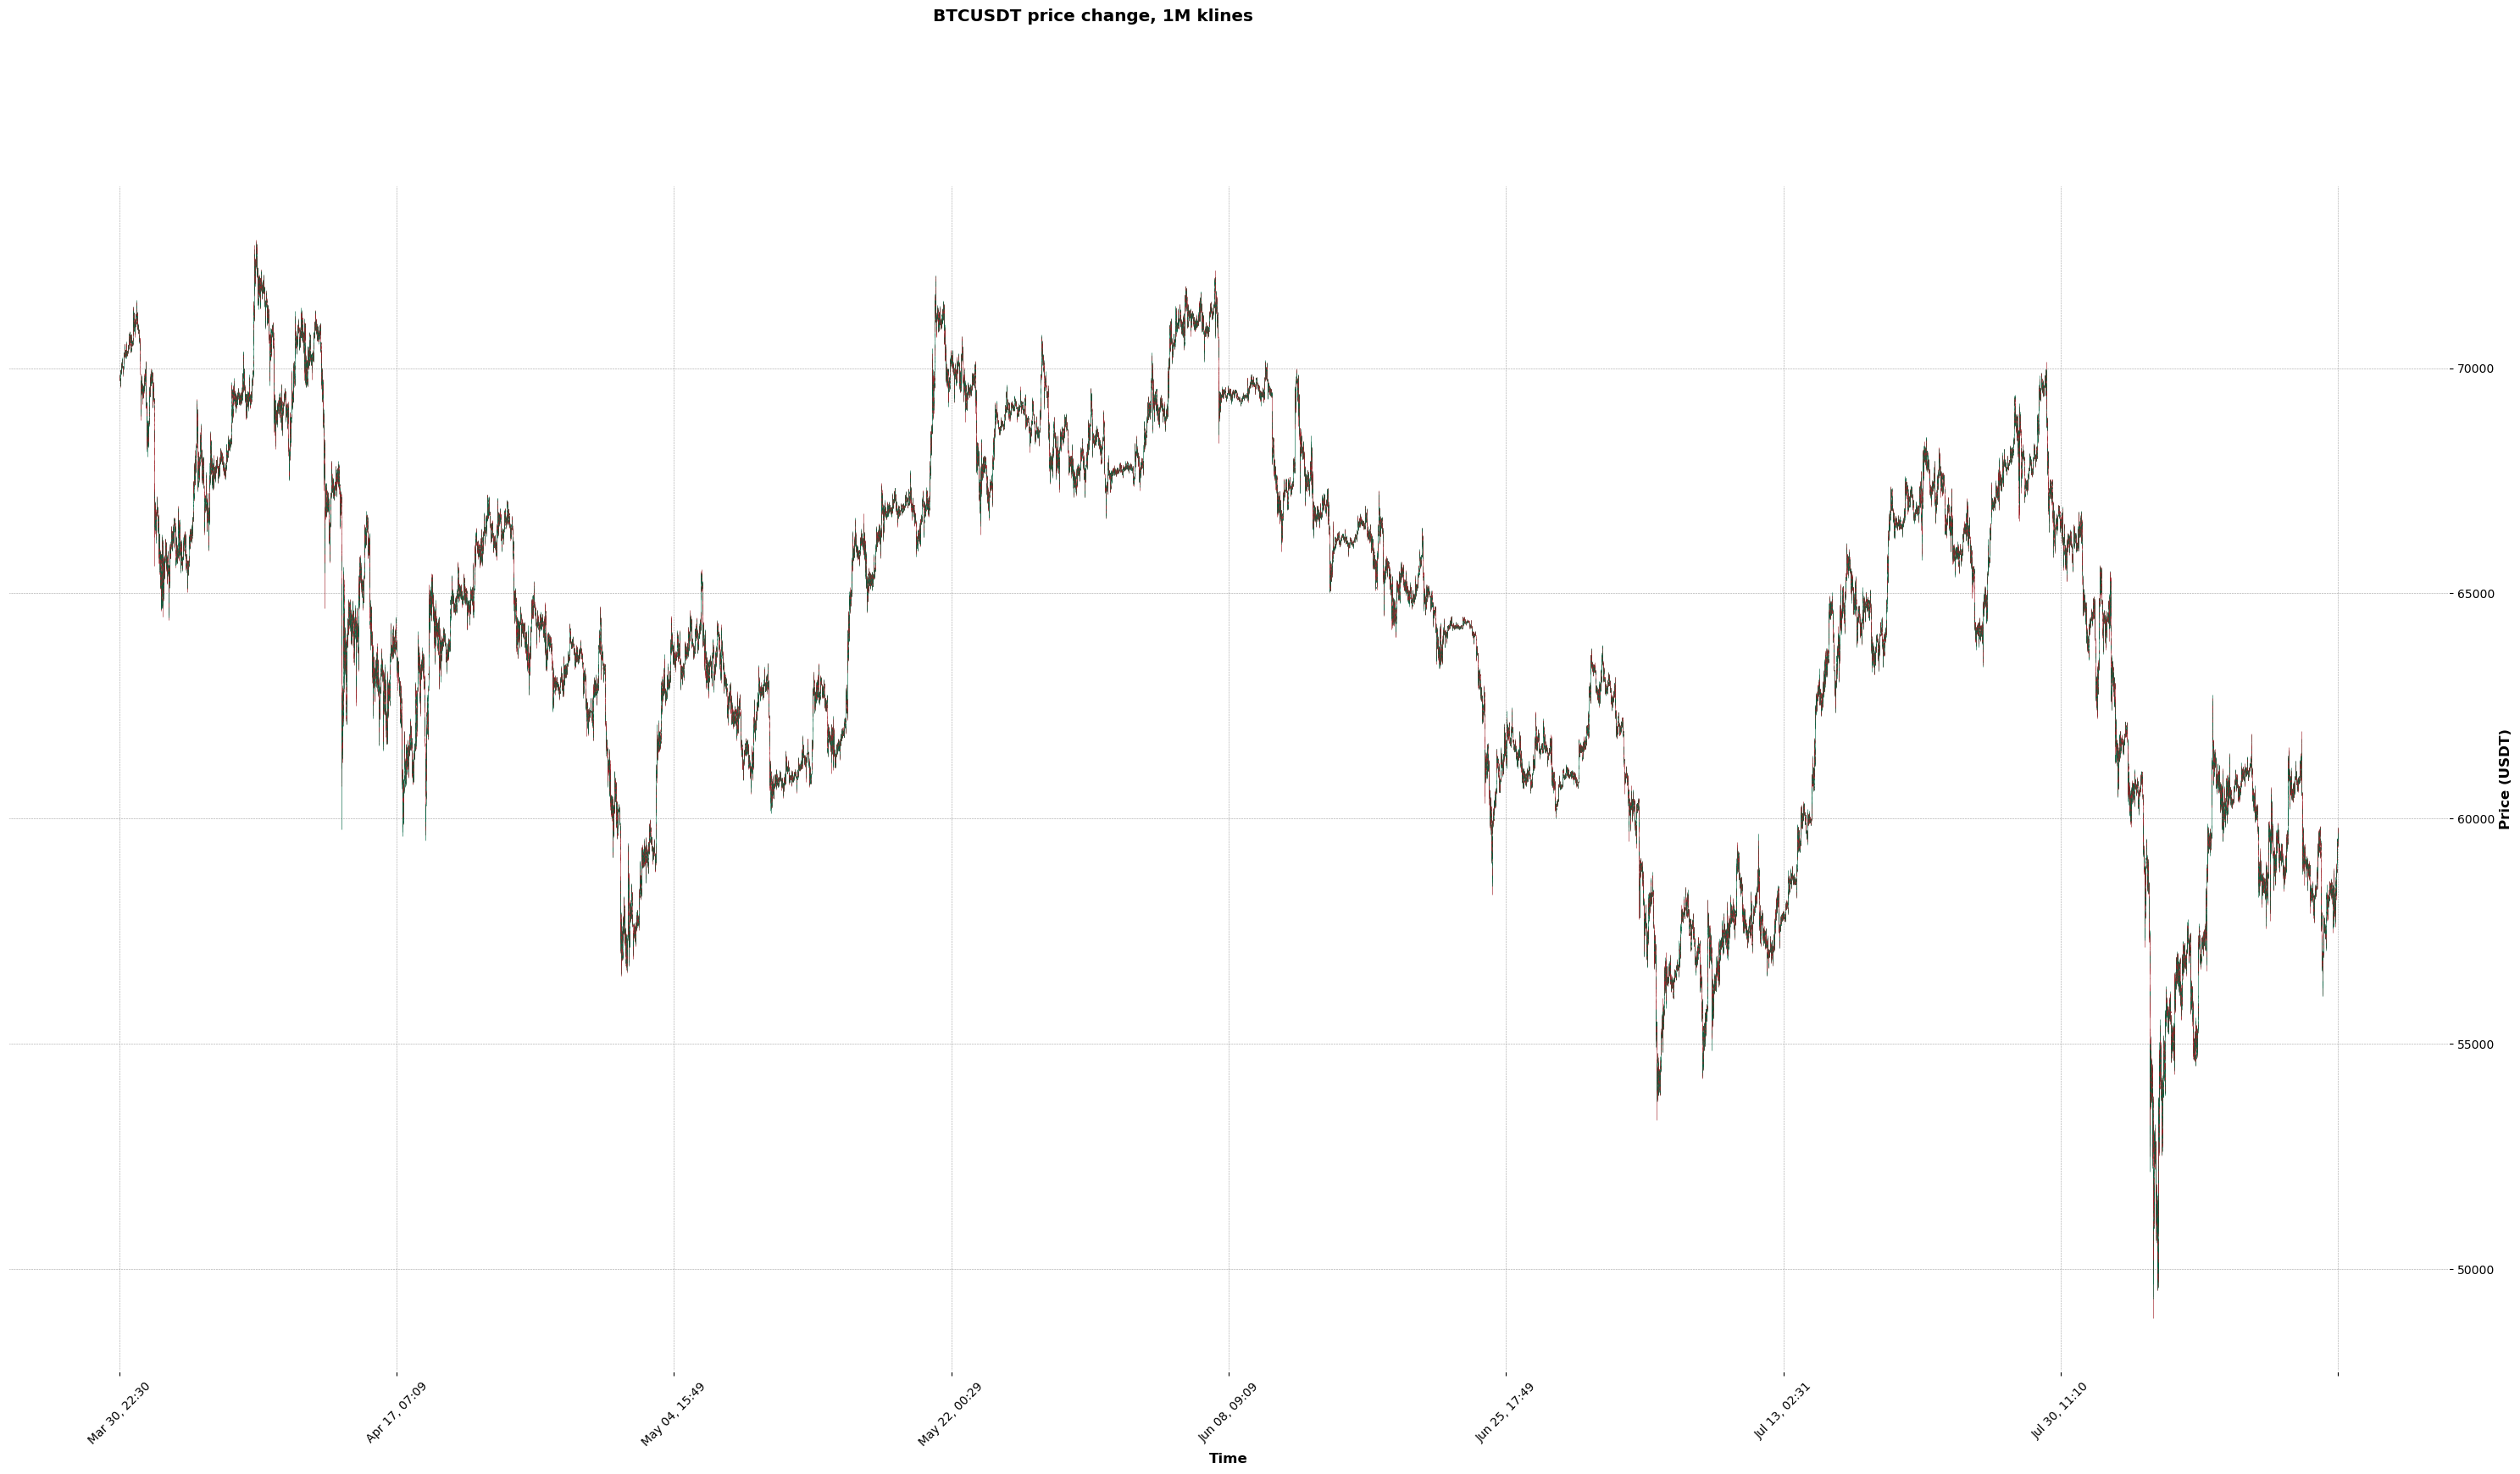

In [ ]:
# let us plot the candles. We use mpf because it's a special lib for plotting trading data and it works great in our case.
# data is too big, but we can see main parts.
mpf.plot(df, type='candle', style='charles',
        title='BTCUSDT price change, 1M klines',
        ylabel='Price (USDT)', xlabel='Time',
        figsize=(40, 20), warn_too_much_data=200000)

In [ ]:
# i like that we have all the trends here on the plot. Firstly it goes down, then sideways movement and all the way up and so on. It's great for learning patterns.

### Outliers handling

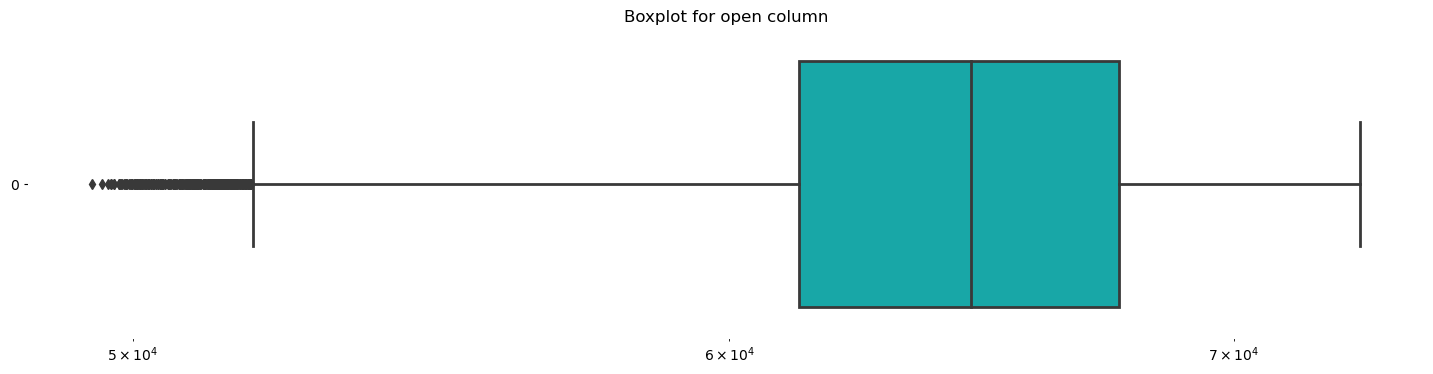

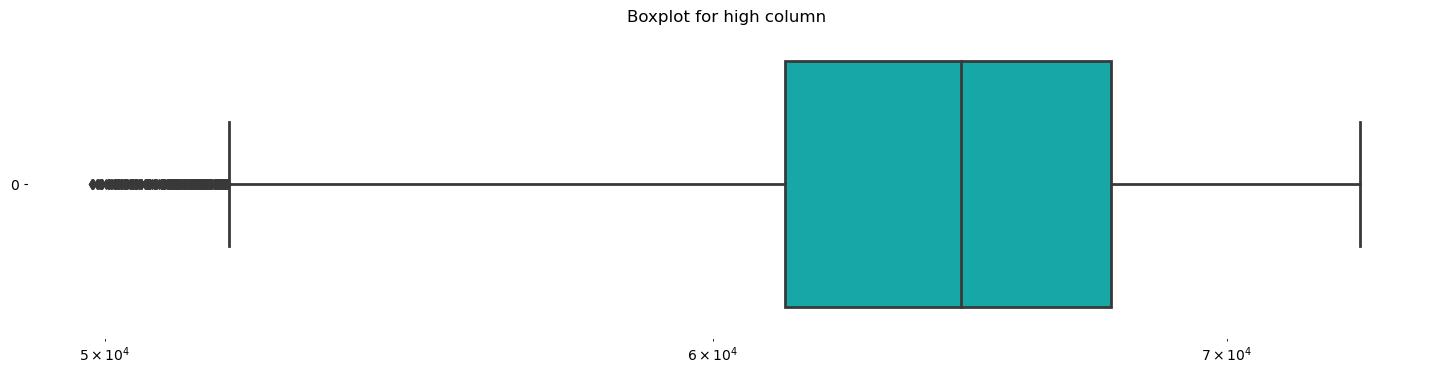

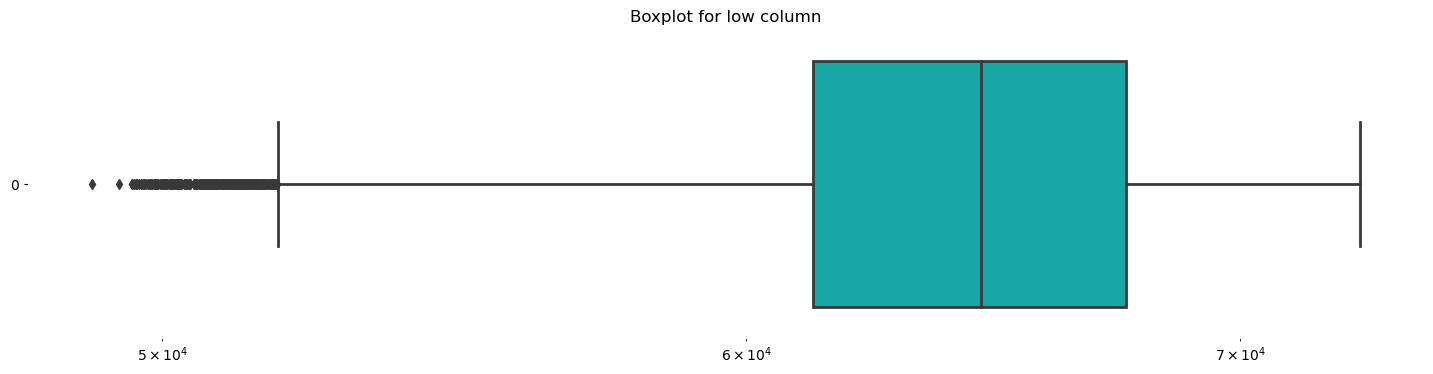

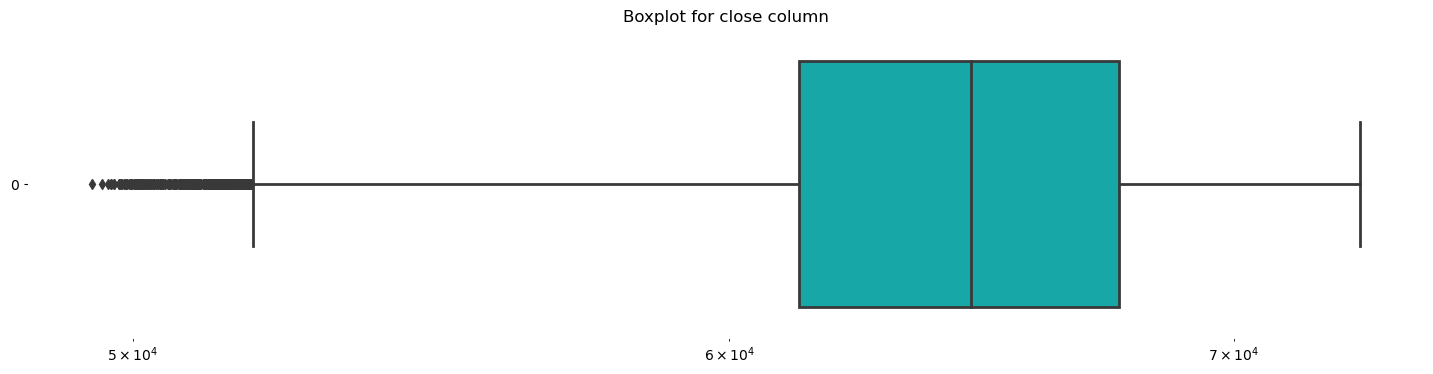

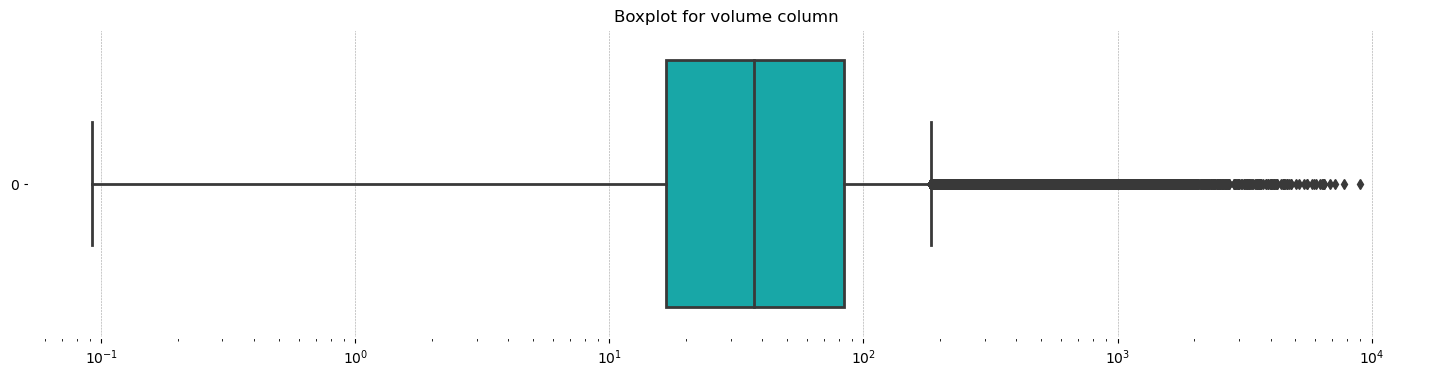

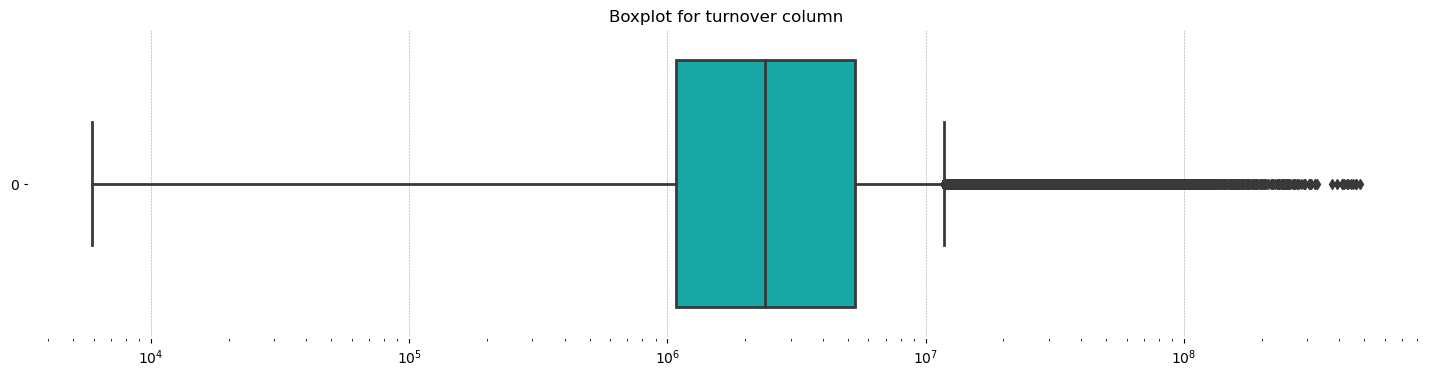

In [ ]:
# now we can draw boxplot to see whether we have outliers or not
for col in df.columns:
    plt.figure(figsize=(18,4))
    plt.title(f'Boxplot for {col} column')
    sns.boxplot(df[col], color='c', orient='h').set_xscale('log')

In [ ]:
# we see outliers in all columns. They are exceeding min and max limits. Let us normalize outliers.
def calc_outliers(data):
    q25 = data.quantile(0.25) # take quantiles of data
    q75 = data.quantile(0.75)
    iqr = q75 - q25 # save median
    bounds = (q25 - 1.5 * iqr, q75 + 1.5 * iqr) # return boundaries tuple
    return bounds

df = df.copy() # make copy so everything can be safe
for col in df.columns:
    boundaries = calc_outliers(df[col])
    df.loc[df[col] < boundaries[0], col] = round(boundaries[0]) # limit outliers within boundaries
    df.loc[df[col] > boundaries[1], col] = round(boundaries[1])

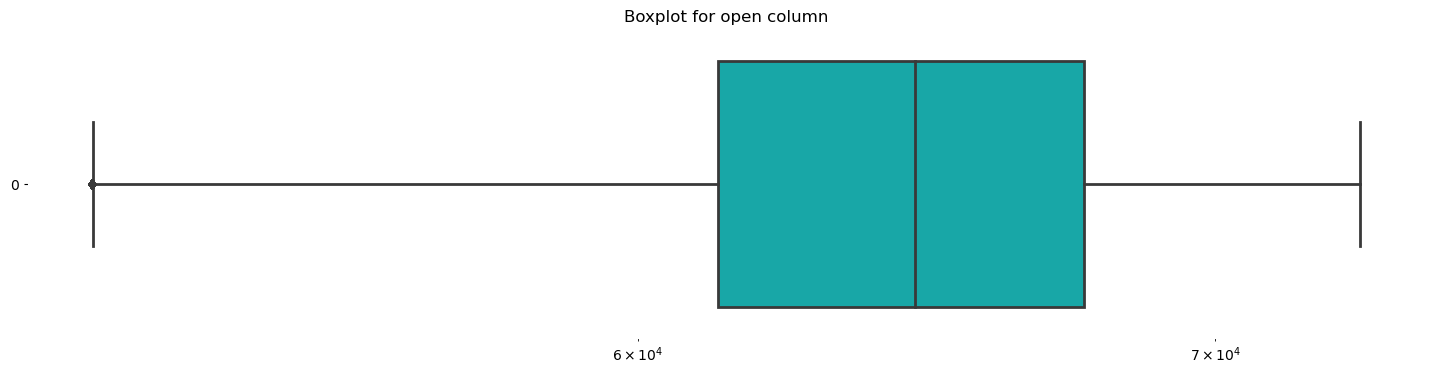

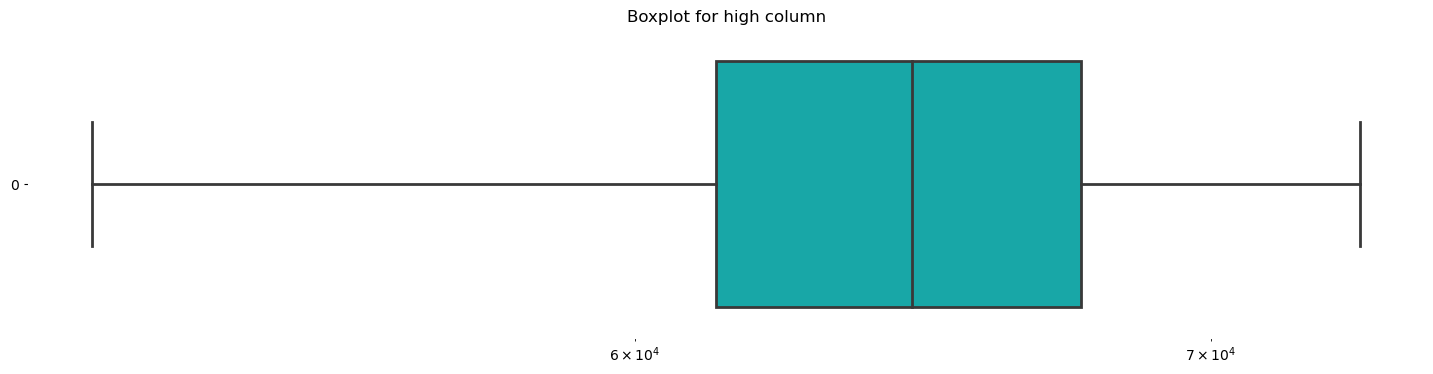

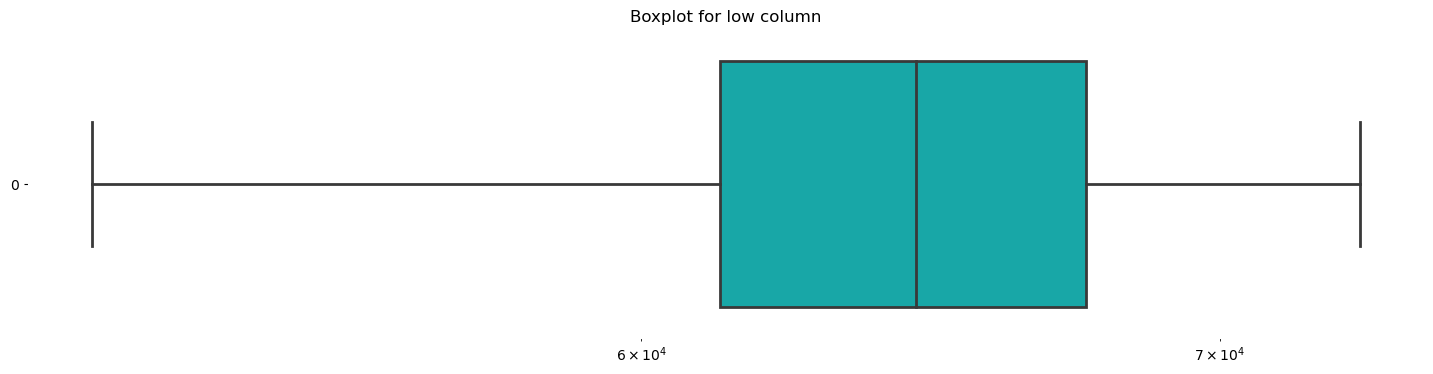

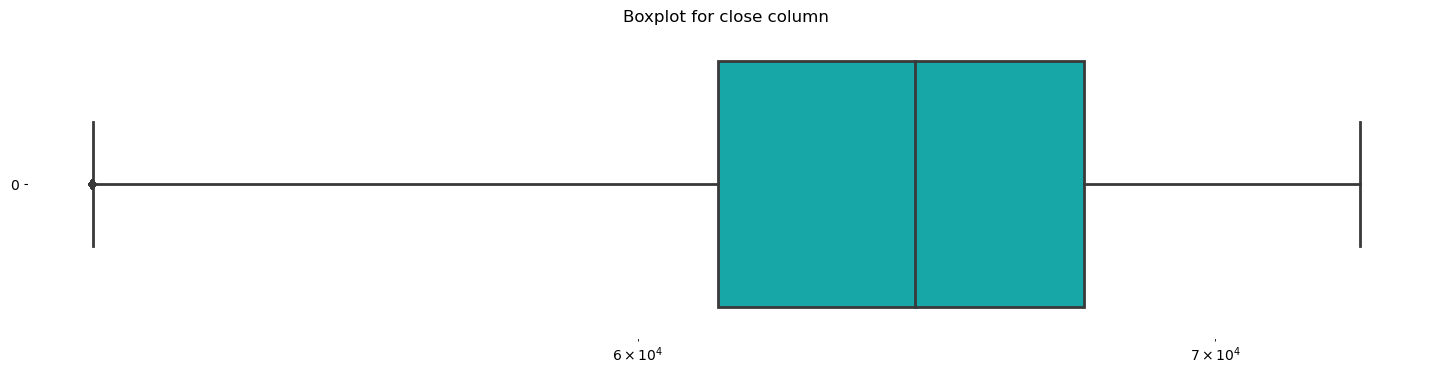

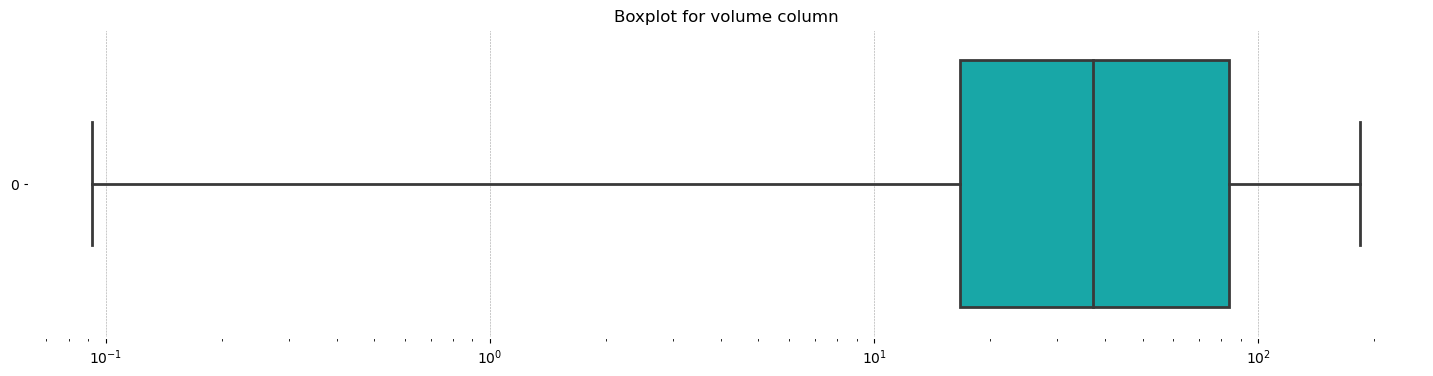

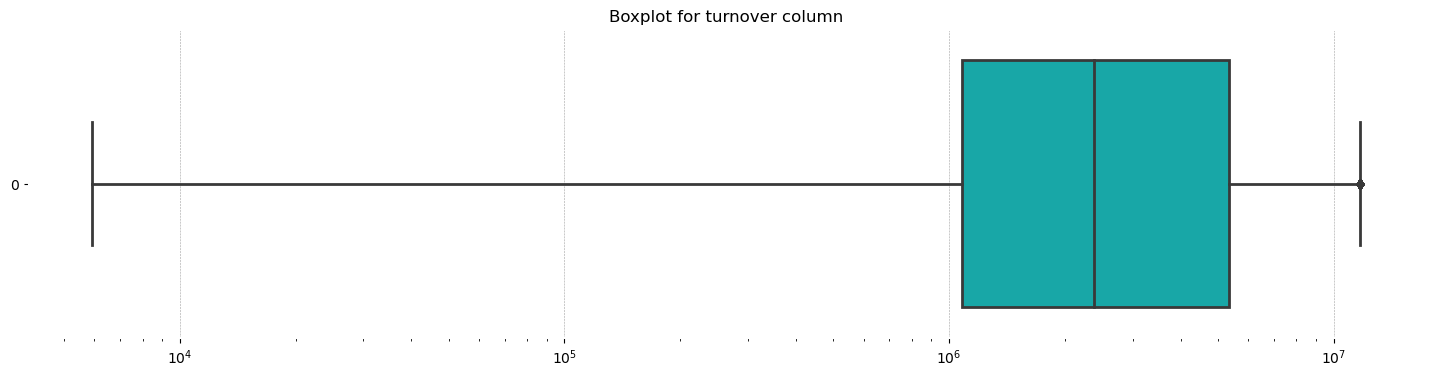

In [ ]:
for col in df.columns:
    plt.figure(figsize=(18,4))
    plt.title(f'Boxplot for {col} column')
    sns.boxplot(df[col], color='c', orient='h').set_xscale('log')

In [ ]:
# everything is great, now we can proceed with feature engineering

## Feature Engineering

### Target creation

In [ ]:
# first of all, we still don't have targets. It's crucial to create them.
# idea is to track price change in percent and if it changes by e.g. 3% target will be 1 (Long), -1 (Short) and 0 (sideways).
pct_change = 0.003
df['price_change'] = df['close'].pct_change()

In [ ]:
df[abs(df['price_change']) > pct_change]

,open,high,low,close,volume,turnover,price_change
timestamp,,,,,,,
2024-03-31 18:38:09.408,70689.6,70968.2,70686.6,70928.1,184.000,1.172096e+07,0.003374
2024-04-01 05:48:48.512,69874.2,69874.7,69412.7,69597.6,184.000,1.172096e+07,-0.003959
2024-04-01 05:50:59.584,69434.8,69487.6,69153.8,69230.9,184.000,1.172096e+07,-0.005797
2024-04-01 06:01:54.944,69107.1,69179.5,68850.2,68971.6,184.000,1.172096e+07,-0.003172
2024-04-01 06:04:06.016,69191.1,69417.7,69153.6,69344.4,184.000,1.172096e+07,0.003434
...,...,...,...,...,...,...,...
2024-08-16 14:47:02.400,58155.8,58167.7,58066.6,58087.0,115.762,6.725805e+06,-0.003033
2024-08-16 15:26:21.696,57976.5,57976.5,57740.2,57740.3,184.000,1.172096e+07,-0.004069
2024-08-16 16:38:27.072,58559.5,58559.6,58294.0,58341.7,184.000,1.172096e+07,-0.003719


In [ ]:
# it's sad, we have only 2294 rows out of 200000 examples. Class imbalance. Ok, we will work it out, we don't want to use less percent value because price change by 1% can be a cause of false breakout

In [ ]:
df['target'] = np.where(df['price_change'].shift(-1) > pct_change, 1,
                        np.where(df['price_change'].shift(-1) < -pct_change, -1,
                                 0))

In [ ]:
df[df['target'] != 0]

,open,high,low,close,volume,turnover,price_change,target
timestamp,,,,,,,,
2024-03-31 18:35:58.336,70632.1,70689.7,70632.0,70689.6,30.838,2.178872e+06,0.000814,1
2024-04-01 05:46:37.440,70046.1,70048.2,69860.0,69874.2,184.000,1.172096e+07,-0.002454,-1
2024-04-01 05:48:48.512,69597.6,69737.9,69597.6,69634.6,184.000,1.172096e+07,0.000532,-1
2024-04-01 06:01:54.944,68971.6,69250.0,68944.5,69191.1,184.000,1.172096e+07,0.000171,-1
2024-04-01 06:01:54.944,69179.3,69297.0,69080.0,69107.1,184.000,1.172096e+07,0.001965,1
...,...,...,...,...,...,...,...,...
2024-08-16 14:44:51.328,58277.4,58307.9,58230.2,58263.7,50.683,2.953161e+06,-0.000235,-1
2024-08-16 15:24:10.624,57977.2,58000.0,57961.8,57976.2,11.898,6.898956e+05,-0.000005,-1
2024-08-16 16:36:16.000,58592.1,58594.1,58541.1,58559.5,74.533,4.365505e+06,-0.000556,-1


In [ ]:
# drop feature from future:
df = df.drop(columns=['price_change'])

In [ ]:
# save df to csv before big changes
df.to_csv('df_preprocessed_wo_features.csv')

### Creating trading features

In [ ]:
# it works, great. Delete rows where indices are duplicated, because timestamps have to be unique for trade patterns features creating. Otherwise we want to save our rows, where target is not 0, because
# they are precious and limited.
imp_target = df[df['target'] != 0] # precious targets
zero_target = df[df['target'] == 0] # zero targets df
imp_target_unique = imp_target[~imp_target.index.duplicated(keep='first')] # delete duplicates separately from non 0 targets
zero_target_unique = zero_target[~zero_target.index.duplicated(keep='first')] # ... and from 0 targets
df = pd.concat([imp_target_unique, zero_target_unique]) # stack our important targets from above
df = df[~df.index.duplicated(keep='first')] # delete duplicates again but important rows are above, so they will be kept
df = df.sort_index() # now we can sort our df
df.head()

,open,high,low,close,volume,turnover,target
timestamp,,,,,,,
2024-03-30 22:30:06.592,69821.1,69821.1,69815.0,69815.0,2.719,1.898336e+05,0
2024-03-30 22:32:17.664,69810.3,69862.9,69810.3,69851.7,116.894,8.164222e+06,0
2024-03-30 22:34:28.736,69825.5,69825.5,69771.6,69771.7,14.075,9.825159e+05,0
2024-03-30 22:36:39.808,69753.3,69770.0,69740.0,69770.0,30.319,2.114865e+06,0
2024-03-30 22:38:50.880,69750.2,69767.9,69750.1,69763.0,7.638,5.328267e+05,0


In [ ]:
df.index.duplicated().sum()

0

In [ ]:
# our targets are safe and indices are unique.
# now we are creating trade features.
df['sma_5'] = talib.SMA(df['close'], timeperiod=5)
df['ema_10'] = talib.EMA(df['close'], timeperiod=10)
df['rsi_9'] = talib.RSI(df['close'], timeperiod=9)
df['macd'], df['macd_signal'], _ = talib.MACD(df['close'], fastperiod=9, slowperiod=20, signalperiod=7)
df['bollinger_high'], df['bollinger_mid'], df['bollinger_low'] = talib.BBANDS(df['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

In [ ]:
# define trade patterns
def is_doji(row, threshold=0.1):
    return abs(row['open'] - row['close']) <= threshold

def is_hammer(row):
    body = abs(row['open'] - row['close'])
    lower_shadow = row['open'] - row['low'] if row['open'] < row['close'] else row['close'] - row['low']
    upper_shadow = row['high'] - row['close'] if row['open'] < row['close'] else row['high'] - row['open']
    return lower_shadow > 2 * body and upper_shadow < body

def is_bullish_engulfing(current_row, previous_row):
    return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
           current_row['open'] < previous_row['close'] and current_row['close'] > previous_row['open']

def is_piercing_line(current_row, previous_row):
    return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
           current_row['open'] < previous_row['low'] and current_row['close'] > (previous_row['open'] + previous_row['close']) / 2

def is_morning_star(current_row, previous_row, pre_previous_row):
    return pre_previous_row['close'] < pre_previous_row['open'] and \
           abs(previous_row['close'] - previous_row['open']) < abs(pre_previous_row['close'] - pre_previous_row['open']) / 2 and \
           current_row['close'] > current_row['open'] and current_row['close'] > (pre_previous_row['close'] + pre_previous_row['open']) / 2

def is_inverted_hammer(row):
    body = abs(row['open'] - row['close'])
    upper_shadow = row['high'] - row['close'] if row['open'] < row['close'] else row['high'] - row['open']
    lower_shadow = row['open'] - row['low'] if row['open'] < row['close'] else row['close'] - row['low']
    return upper_shadow > 2 * body and lower_shadow < body

def is_three_white_soldiers(df, idx):
    if idx < 2:
        return False
    current = df.iloc[idx]
    prev1 = df.iloc[idx - 1]
    prev2 = df.iloc[idx - 2]
    return all([current['close'] > current['open'], prev1['close'] > prev1['open'], prev2['close'] > prev2['open']]) and \
           all([current['open'] > prev1['close'], prev1['open'] > prev2['close']]) and \
           all([current['close'] > prev1['close'], prev1['close'] > prev2['close']])

def is_harami_cross(current_row, prev_row):
    return abs(current_row['open'] - current_row['close']) < (current_row['high'] - current_row['low']) * 0.1 and \
           prev_row['open'] > prev_row['close'] and current_row['high'] < prev_row['open'] and current_row['low'] > prev_row['close']

def is_bearish_engulfing(current_row, previous_row):
    return previous_row['close'] > previous_row['open'] and current_row['close'] < current_row['open'] and \
           current_row['open'] > previous_row['close'] and current_row['close'] < previous_row['open']

def is_evening_star(current_row, previous_row, pre_previous_row):
    return pre_previous_row['close'] > pre_previous_row['open'] and \
           abs(previous_row['close'] - previous_row['open']) < abs(pre_previous_row['close'] - pre_previous_row['open']) / 2 and \
           current_row['close'] < current_row['open'] and current_row['close'] < (pre_previous_row['close'] + pre_previous_row['open']) / 2

In [ ]:
# create trade patterns
df['is_doji'] = df.apply(lambda row: is_doji(row), axis=1)
df['is_hammer'] = df.apply(lambda row: is_hammer(row), axis=1)
df['is_inverted_hammer'] = df.apply(lambda row: is_inverted_hammer(row), axis=1)
df['is_bullish_engulfing'] = df.apply(lambda row: is_bullish_engulfing(row, df.iloc[df.index.get_loc(row.name) - 1]) if df.index.get_loc(row.name) > 0 else False, axis=1)
df['is_piercing_line'] = df.apply(lambda row: is_piercing_line(row, df.iloc[df.index.get_loc(row.name) - 1]) if df.index.get_loc(row.name) > 0 else False, axis=1)
df['is_morning_star'] = df.apply(lambda row: is_morning_star(row, df.iloc[df.index.get_loc(row.name) - 1], df.iloc[df.index.get_loc(row.name) - 2]) if df.index.get_loc(row.name) > 1 else False, axis=1)
df['is_three_white_soldiers'] = df.apply(lambda row: is_three_white_soldiers(df, df.index.get_loc(row.name)), axis=1)
df['is_harami_cross'] = df.apply(lambda row: is_harami_cross(row, df.iloc[df.index.get_loc(row.name) - 1]) if df.index.get_loc(row.name) > 0 else False, axis=1)
df['is_bearish_engulfing'] = df.apply(lambda row: is_bearish_engulfing(row, df.iloc[df.index.get_loc(row.name) - 1]) if df.index.get_loc(row.name) > 0 else False, axis=1)
df['is_evening_star'] = df.apply(lambda row: is_evening_star(row, df.iloc[df.index.get_loc(row.name) - 1], df.iloc[df.index.get_loc(row.name) - 2]) if df.index.get_loc(row.name) > 1 else False, axis=1)

In [ ]:
df.tail()

,open,high,low,close,volume,turnover,target,sma_5,ema_10,rsi_9,...,is_doji,is_hammer,is_inverted_hammer,is_bullish_engulfing,is_piercing_line,is_morning_star,is_three_white_soldiers,is_harami_cross,is_bearish_engulfing,is_evening_star
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-08-16 19:39:46.048,59659.6,59797.3,59659.6,59778.9,94.522,5.648011e+06,0,59707.36,59688.219272,66.824983,...,False,False,False,True,True,False,False,False,False,False
2024-08-16 19:41:57.120,59754.4,59778.6,59747.9,59752.1,63.776,3.811398e+06,0,59706.58,59699.833950,62.833332,...,False,False,False,False,False,False,False,False,False,False
2024-08-16 19:44:08.192,59656.8,59696.6,59638.0,59676.0,83.083,4.957955e+06,0,59711.80,59695.500504,52.764913,...,False,False,False,False,False,False,False,False,False,False
2024-08-16 19:46:19.264,59650.0,59650.1,59584.7,59613.2,151.383,9.024101e+06,0,59703.96,59680.536776,45.931888,...,False,False,False,False,False,False,False,False,False,False
2024-08-16 19:48:30.336,59676.4,59695.7,59641.5,59663.8,32.312,1.928031e+06,0,59696.80,59677.493726,51.611906,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
for col in df.columns[::-1][:10]:
    print(f'{col} shape: {df[df[col] == True].shape[0]}')

is_evening_star shape: 3811
is_bearish_engulfing shape: 1831
is_harami_cross shape: 215
is_three_white_soldiers shape: 1547
is_morning_star shape: 3813
is_piercing_line shape: 1736
is_bullish_engulfing shape: 1857
is_inverted_hammer shape: 5269
is_hammer shape: 5240
is_doji shape: 2096


In [ ]:
# we see that it worked and our patterns were applied. Let's see if it correlate with targets, e.g. for Long
for col in df.columns[::-1][:10]:
    print(f'{col} shape: {df[(df[col] == True) & (df["target"] == 1)].shape[0]}')

is_evening_star shape: 36
is_bearish_engulfing shape: 17
is_harami_cross shape: 0
is_three_white_soldiers shape: 23
is_morning_star shape: 39
is_piercing_line shape: 10
is_bullish_engulfing shape: 11
is_inverted_hammer shape: 46
is_hammer shape: 48
is_doji shape: 4


In [ ]:
# for short
for col in df.columns[::-1][:10]:
    print(f'{col} shape: {df[(df[col] == True) & (df["target"] == -1)].shape[0]}')

is_evening_star shape: 46
is_bearish_engulfing shape: 25
is_harami_cross shape: 3
is_three_white_soldiers shape: 28
is_morning_star shape: 48
is_piercing_line shape: 9
is_bullish_engulfing shape: 15
is_inverted_hammer shape: 44
is_hammer shape: 53
is_doji shape: 1


In [ ]:
# interesting that sometimes targets are correct, sometimes not. E.g. morning_star for short is not a good idea. Okay we will have more indicators and see in future whether our model work or not. Anyway,
# our targets are just price difference by 3%

In [ ]:
df['atr'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=7)
df['historical_volatility'] = df['close'].pct_change().rolling(window=14).std() * np.sqrt(252)
df['volume_mean_5'] = df['volume'].rolling(window=5).mean()
df['volume_mean_30'] = df['volume'].rolling(window=30).mean()
df['parabolic_sar'] = talib.SAR(df['high'], df['low'], acceleration=0.02, maximum=0.3)
df['adx'] = talib.ADX(df['high'], df['low'], df['close'], timeperiod=7)
df['stochastic_oscillator_k'], df['sctochastic_oscillator_d'] = talib.STOCH(df['high'], df['low'], df['close'],
                                                                            fastk_period=7, slowk_period=5, slowk_matype=0,
                                                                            slowd_period=5, slowd_matype=0)
df['cci'] = talib.CCI(df['high'], df['low'], df['close'], timeperiod=10)
df['sma_50'] = talib.SMA(df['close'], timeperiod=50)
df['sma_200'] = talib.SMA(df['close'], timeperiod=200)
df['ema_20'] = talib.EMA(df['close'], timeperiod=20)
df['ema_50'] = talib.EMA(df['close'], timeperiod=50)

df.dropna(inplace=True)

In [ ]:
df.shape

(91354, 38)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91354 entries, 2024-03-31 05:44:49.920000 to 2024-08-16 19:48:30.336000
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   open                      91354 non-null  float64
 1   high                      91354 non-null  float64
 2   low                       91354 non-null  float64
 3   close                     91354 non-null  float64
 4   volume                    91354 non-null  float64
 5   turnover                  91354 non-null  float64
 6   target                    91354 non-null  int64  
 7   sma_5                     91354 non-null  float64
 8   ema_10                    91354 non-null  float64
 9   rsi_9                     91354 non-null  float64
 10  macd                      91354 non-null  float64
 11  macd_signal               91354 non-null  float64
 12  bollinger_high            91354 non-null  float64
 13  bollinger_mi

In [ ]:
df.to_csv('df_before_balancing.csv')

In [ ]:
# also i want to remove class imbalance, it's huge problem for model generalization characteristics. We are going to use resampling
target_samples = df[df['target'] != 0]
other_samples = df[df['target'] == 0]

target_count = len(target_samples)

downsampled = resample(other_samples, replace=False, n_samples=target_count, random_state=42)

df = pd.concat([downsampled, target_samples])
df = df.sort_index()

In [ ]:
df.shape

(4004, 38)

In [ ]:
# everything is ready, let us see corr heatmap

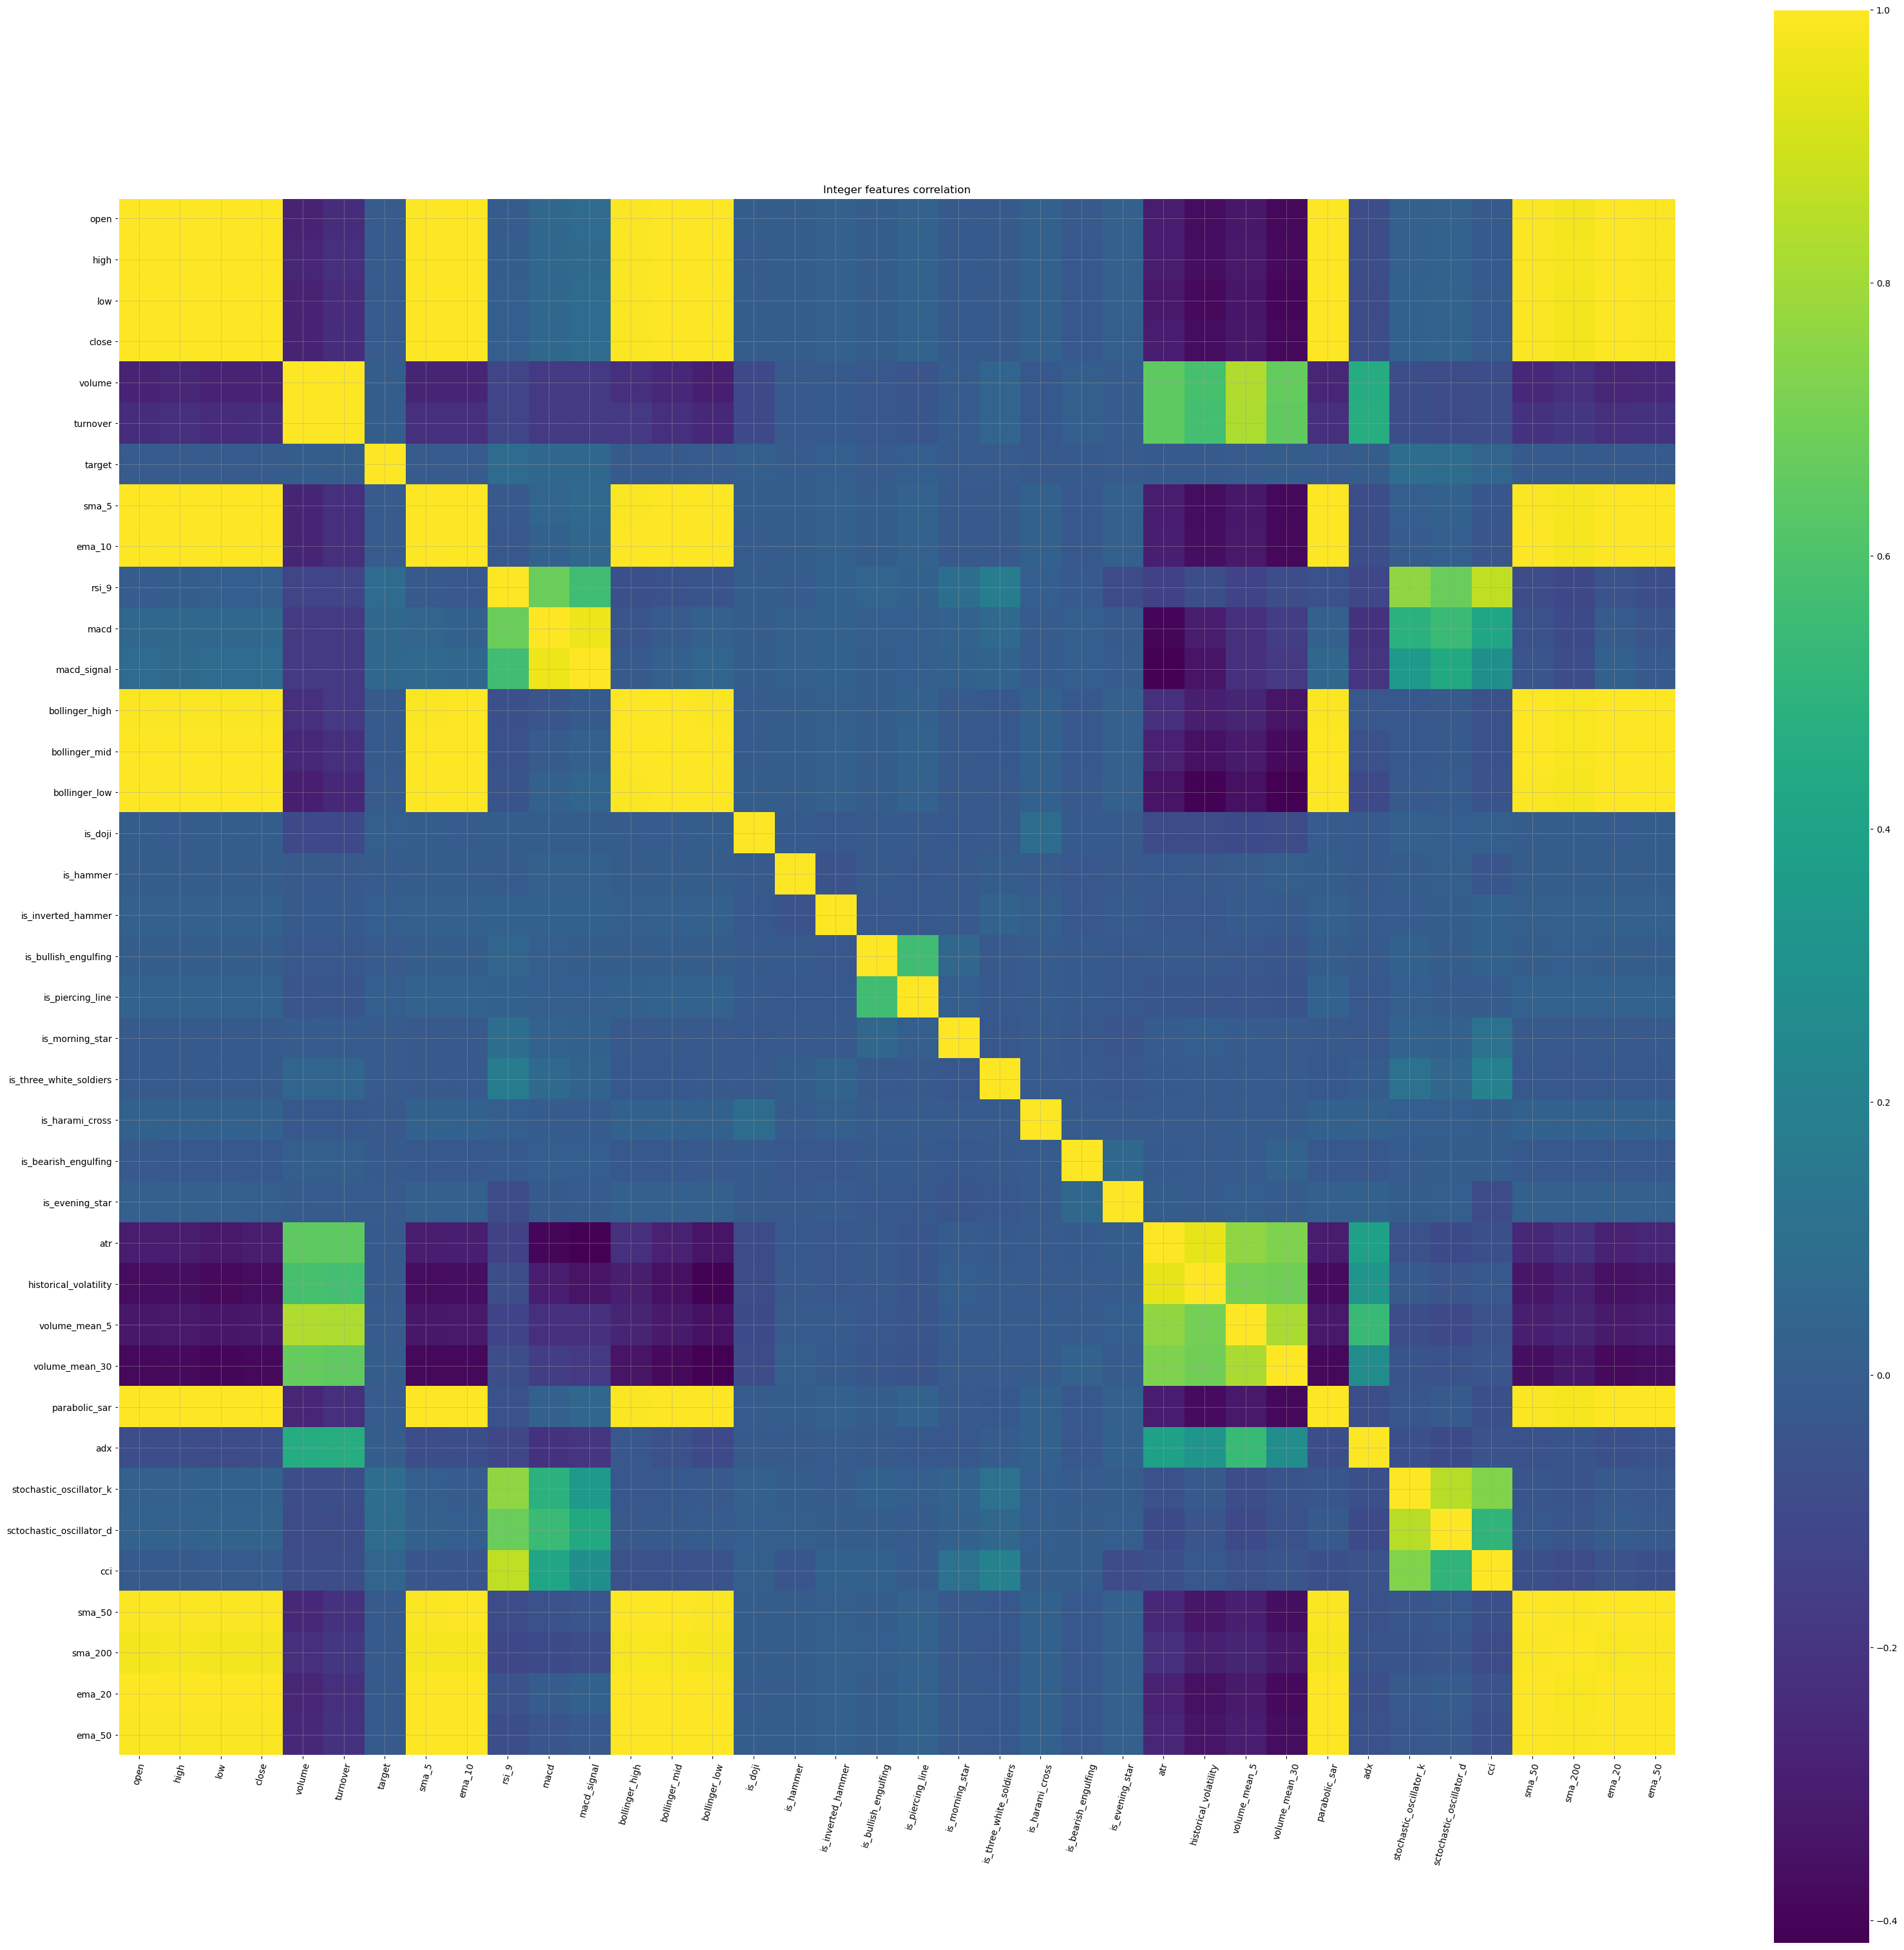

In [ ]:
plt.figure(figsize=(39,39))

columns = df.corr().columns.tolist()
plt.imshow(df.corr())

plt.title('Integer features correlation')
plt.xticks(range(0, len(columns)), columns, rotation=75)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show();

In correlation heatmap we can see good default OHLCVT correlation between them and e.g. bollinger bands, parabolic, SMAs, EMAs, volume mean. Also we see volatility reverse corr with OHLCVT. Of course these correlations are obvious because these indicators are usually like price mean or exp. price mean, volume mean and so on. Target column as well has some correlations with ATR, volatility and volume mean, it's good.

In [ ]:
df.to_csv('df_preprocessed.csv')

### Numeric scaling

In [ ]:
# our main goal is to use catboost for model training as one of the SOTA non-neural-nets solutions, but for further research we want to have more opportunities to work with the data, e.g. to use neural nets
# or linear models. P.S.: Catboost is not afraid of working with not scaled data because it uses gradient boosting above decision trees.
# initialize StandardScaler and save df with numeric columns in std_data
numerical_cols = [col for col in df.columns if col != 'target']
std_scaler = StandardScaler()
std_data = df[numerical_cols]

In [ ]:
# fit std_scaler to data
std_scaler.fit(std_data)

StandardScaler()

In [ ]:
# transform data and print its matrix and shape
scaled_data = std_scaler.transform(std_data)
print(scaled_data, 'Shape:', scaled_data.shape)

[[ 1.58615861  1.57964989  1.59379261 ...  1.54092819  1.57493758
   1.57237926]
 [ 1.6158028   1.60990311  1.61692075 ...  1.55238733  1.58708836
   1.57723421]
 [ 1.65036233  1.64831402  1.65786146 ...  1.58191333  1.65406147
   1.63722394]
 ...
 [-0.87346145 -0.87681587 -0.86436403 ... -1.10178419 -0.94563906
  -0.99939237]
 [-0.71793272 -0.72871249 -0.71509424 ... -1.05283944 -0.76657966
  -0.83136802]
 [-0.74100865 -0.75336003 -0.74358134 ... -1.04972807 -0.76345287
  -0.82587169]] Shape: (4004, 37)


In [ ]:
# create cols names for naming scaled data
scaled_cols = [col + '_std' for col in numerical_cols]
scaled_cols

['open_std',
 'high_std',
 'low_std',
 'close_std',
 'volume_std',
 'turnover_std',
 'sma_5_std',
 'ema_10_std',
 'rsi_9_std',
 'macd_std',
 'macd_signal_std',
 'bollinger_high_std',
 'bollinger_mid_std',
 'bollinger_low_std',
 'is_doji_std',
 'is_hammer_std',
 'is_inverted_hammer_std',
 'is_bullish_engulfing_std',
 'is_piercing_line_std',
 'is_morning_star_std',
 'is_three_white_soldiers_std',
 'is_harami_cross_std',
 'is_bearish_engulfing_std',
 'is_evening_star_std',
 'atr_std',
 'historical_volatility_std',
 'volume_mean_5_std',
 'volume_mean_30_std',
 'parabolic_sar_std',
 'adx_std',
 'stochastic_oscillator_k_std',
 'sctochastic_oscillator_d_std',
 'cci_std',
 'sma_50_std',
 'sma_200_std',
 'ema_20_std',
 'ema_50_std']

In [ ]:
# add scaled data to df
df[scaled_cols] = scaled_data

In [ ]:
df_new = df.drop(columns=numerical_cols)

In [ ]:
# check that we've done everything right
df_new.tail()

,target,open_std,high_std,low_std,close_std,volume_std,turnover_std,sma_5_std,ema_10_std,rsi_9_std,...,volume_mean_30_std,parabolic_sar_std,adx_std,stochastic_oscillator_k_std,sctochastic_oscillator_d_std,cci_std,sma_50_std,sma_200_std,ema_20_std,ema_50_std
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-08-16 17:30:52.800,1,-0.960306,-0.961664,-0.949565,-0.948918,-0.256142,-0.341008,-0.977543,-0.981590,1.055008,...,0.204729,-1.010861,-1.130555,0.526151,0.147029,1.250714,-1.049096,-1.108066,-0.997601,-1.037995
2024-08-16 17:35:14.944,0,-0.936251,-0.932131,-0.924940,-0.924332,-0.187659,-0.275438,-0.942890,-0.959600,0.923646,...,0.162193,-1.004355,-0.326609,1.357730,0.675305,1.066759,-1.040864,-1.106976,-0.983294,-1.029634
2024-08-16 17:57:05.664,1,-0.873461,-0.876816,-0.864364,-0.869393,1.211241,1.103967,-0.907263,-0.920132,1.622490,...,0.023041,-0.962823,1.266941,0.767172,0.152814,2.003439,-1.004008,-1.101784,-0.945639,-0.999392
2024-08-16 19:31:01.760,0,-0.717933,-0.728712,-0.715094,-0.717935,1.211241,1.225107,-0.723944,-0.741806,1.230320,...,0.741375,-0.760070,0.820463,1.692026,1.619999,0.710022,-0.829100,-1.052839,-0.766580,-0.831368
2024-08-16 19:35:23.904,0,-0.741009,-0.753360,-0.743581,-0.740477,0.575937,0.458422,-0.728305,-0.742857,0.397515,...,0.808898,-0.710517,0.052253,0.848797,1.547837,-0.552853,-0.821368,-1.049728,-0.763453,-0.825872


In [ ]:
# save file for further modelling
df_new.to_csv('df_final.csv')

## Modelling

### Catboost

In [ ]:
# split by train and test
X = df_new.drop(['target'], axis=1)
y = df_new.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# define catboost with eval_metric as 'Accuracy' so it can fit to our demands
catboost_v1 = CatBoostClassifier(random_state=42, eval_metric='Accuracy')

In [ ]:
# fit the model with plot=True, because we want to see loss curve as well. Also we give the model eval_set
catboost_v1.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True, verbose=20)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.11052
0:	learn: 0.6331564	test: 0.6192260	best: 0.6192260 (0)	total: 68.7ms	remaining: 1m 8s
20:	learn: 0.6921636	test: 0.6154806	best: 0.6342072 (17)	total: 257ms	remaining: 12s
40:	learn: 0.7130815	test: 0.6229713	best: 0.6342072 (17)	total: 426ms	remaining: 9.96s
60:	learn: 0.7302529	test: 0.6279650	best: 0.6379526 (51)	total: 586ms	remaining: 9.03s
80:	learn: 0.7483609	test: 0.6242197	best: 0.6379526 (51)	total: 769ms	remaining: 8.72s
100:	learn: 0.7661567	test: 0.6204744	best: 0.6379526 (51)	total: 917ms	remaining: 8.16s
120:	learn: 0.7805183	test: 0.6304619	best: 0.6379526 (51)	total: 1.08s	remaining: 7.83s
140:	learn: 0.7964408	test: 0.6254682	best: 0.6379526 (51)	total: 1.26s	remaining: 7.71s
160:	learn: 0.8095535	test: 0.6254682	best: 0.6379526 (51)	total: 1.44s	remaining: 7.53s
180:	learn: 0.8154855	test: 0.6254682	best: 0.6379526 (51)	total: 1.63s	remaining: 7.38s
200:	learn: 0.8348423	test: 0.6279650	best: 0.6379526 (51)	total: 1.79s	remaining: 7.13s


In [ ]:
# multiclass loss curve seems very smooth and organic, but we see that after 100 iteration train loss curve goes
# all the way down, but test curve goes up. When test curve goes up it's an indicator of overfitting, but luckily
# we had early_stopping.
# accuracy curve can't cross 0.64 in test and remains almost the same
# let's predict on train
catboost_pred_train_v1 = catboost_v1.predict(X_train)
accuracy_catboost_train_v1 = accuracy_score(y_train, catboost_pred_train_v1)

In [ ]:
accuracy_catboost_train_v1

0.7277552294723697

In [ ]:
# good, better than our goal (60%), let's see test prediction results
catboost_pred_test_v1 = catboost_v1.predict(X_test)
accuracy_catboost_test_v1 = accuracy_score(y_test, catboost_pred_test_v1)

In [ ]:
accuracy_catboost_test_v1

0.6379525593008739

In [ ]:
# big difference between train and test, but early_stopping seems like saving us
catboost_v1_cvs = cross_val_score(catboost_v1, X, y,
                                 cv=5, scoring='accuracy', verbose=False)

Learning rate set to 0.083967
0:	learn: 0.6219170	total: 11.3ms	remaining: 11.3s
1:	learn: 0.6365907	total: 19ms	remaining: 9.5s
2:	learn: 0.6434593	total: 26ms	remaining: 8.65s
3:	learn: 0.6447081	total: 33.5ms	remaining: 8.34s
4:	learn: 0.6456447	total: 40.6ms	remaining: 8.08s
5:	learn: 0.6447081	total: 48ms	remaining: 7.95s
6:	learn: 0.6415860	total: 55.4ms	remaining: 7.86s
7:	learn: 0.6468935	total: 62.9ms	remaining: 7.79s
8:	learn: 0.6506400	total: 70.2ms	remaining: 7.73s
9:	learn: 0.6534499	total: 77.7ms	remaining: 7.69s
10:	learn: 0.6550109	total: 85.2ms	remaining: 7.66s
11:	learn: 0.6568842	total: 92.2ms	remaining: 7.59s
12:	learn: 0.6593818	total: 99.7ms	remaining: 7.57s
13:	learn: 0.6543865	total: 107ms	remaining: 7.52s
14:	learn: 0.6612551	total: 114ms	remaining: 7.5s
15:	learn: 0.6612551	total: 122ms	remaining: 7.47s
16:	learn: 0.6681236	total: 129ms	remaining: 7.45s
17:	learn: 0.6653138	total: 135ms	remaining: 7.39s
18:	learn: 0.6653138	total: 143ms	remaining: 7.38s
19:	le

185:	learn: 0.8036216	total: 1.42s	remaining: 6.21s
186:	learn: 0.8048704	total: 1.43s	remaining: 6.22s
187:	learn: 0.8048704	total: 1.44s	remaining: 6.21s
188:	learn: 0.8054948	total: 1.45s	remaining: 6.2s
189:	learn: 0.8054948	total: 1.45s	remaining: 6.2s
190:	learn: 0.8067437	total: 1.46s	remaining: 6.19s
191:	learn: 0.8070559	total: 1.47s	remaining: 6.2s
192:	learn: 0.8061193	total: 1.48s	remaining: 6.2s
193:	learn: 0.8079925	total: 1.49s	remaining: 6.19s
194:	learn: 0.8089291	total: 1.5s	remaining: 6.18s
195:	learn: 0.8079925	total: 1.51s	remaining: 6.19s
196:	learn: 0.8092413	total: 1.52s	remaining: 6.19s
197:	learn: 0.8092413	total: 1.53s	remaining: 6.18s
198:	learn: 0.8104902	total: 1.53s	remaining: 6.18s
199:	learn: 0.8114268	total: 1.54s	remaining: 6.17s
200:	learn: 0.8117390	total: 1.55s	remaining: 6.16s
201:	learn: 0.8120512	total: 1.56s	remaining: 6.15s
202:	learn: 0.8114268	total: 1.56s	remaining: 6.14s
203:	learn: 0.8114268	total: 1.57s	remaining: 6.13s
204:	learn: 0.813

345:	learn: 0.8685607	total: 2.62s	remaining: 4.96s
346:	learn: 0.8694973	total: 2.63s	remaining: 4.96s
347:	learn: 0.8694973	total: 2.64s	remaining: 4.95s
348:	learn: 0.8701218	total: 2.65s	remaining: 4.94s
349:	learn: 0.8701218	total: 2.66s	remaining: 4.94s
350:	learn: 0.8707462	total: 2.67s	remaining: 4.93s
351:	learn: 0.8707462	total: 2.67s	remaining: 4.92s
352:	learn: 0.8710584	total: 2.68s	remaining: 4.91s
353:	learn: 0.8726194	total: 2.69s	remaining: 4.9s
354:	learn: 0.8726194	total: 2.69s	remaining: 4.89s
355:	learn: 0.8726194	total: 2.7s	remaining: 4.89s
356:	learn: 0.8726194	total: 2.71s	remaining: 4.88s
357:	learn: 0.8729316	total: 2.71s	remaining: 4.87s
358:	learn: 0.8726194	total: 2.72s	remaining: 4.86s
359:	learn: 0.8748049	total: 2.73s	remaining: 4.85s
360:	learn: 0.8748049	total: 2.74s	remaining: 4.85s
361:	learn: 0.8760537	total: 2.75s	remaining: 4.84s
362:	learn: 0.8748049	total: 2.75s	remaining: 4.83s
363:	learn: 0.8748049	total: 2.76s	remaining: 4.82s
364:	learn: 0.

528:	learn: 0.9132064	total: 4.03s	remaining: 3.59s
529:	learn: 0.9128942	total: 4.04s	remaining: 3.58s
530:	learn: 0.9132064	total: 4.05s	remaining: 3.58s
531:	learn: 0.9138308	total: 4.06s	remaining: 3.57s
532:	learn: 0.9138308	total: 4.07s	remaining: 3.56s
533:	learn: 0.9138308	total: 4.07s	remaining: 3.55s
534:	learn: 0.9147674	total: 4.08s	remaining: 3.55s
535:	learn: 0.9147674	total: 4.09s	remaining: 3.54s
536:	learn: 0.9144552	total: 4.09s	remaining: 3.53s
537:	learn: 0.9150796	total: 4.1s	remaining: 3.52s
538:	learn: 0.9144552	total: 4.11s	remaining: 3.51s
539:	learn: 0.9147674	total: 4.12s	remaining: 3.51s
540:	learn: 0.9147674	total: 4.12s	remaining: 3.5s
541:	learn: 0.9150796	total: 4.13s	remaining: 3.49s
542:	learn: 0.9153918	total: 4.14s	remaining: 3.48s
543:	learn: 0.9150796	total: 4.14s	remaining: 3.47s
544:	learn: 0.9157040	total: 4.15s	remaining: 3.47s
545:	learn: 0.9160162	total: 4.16s	remaining: 3.46s
546:	learn: 0.9157040	total: 4.17s	remaining: 3.45s
547:	learn: 0.

691:	learn: 0.9384952	total: 5.26s	remaining: 2.34s
692:	learn: 0.9381830	total: 5.27s	remaining: 2.33s
693:	learn: 0.9384952	total: 5.27s	remaining: 2.33s
694:	learn: 0.9391196	total: 5.28s	remaining: 2.32s
695:	learn: 0.9391196	total: 5.29s	remaining: 2.31s
696:	learn: 0.9391196	total: 5.3s	remaining: 2.3s
697:	learn: 0.9394318	total: 5.3s	remaining: 2.29s
698:	learn: 0.9394318	total: 5.31s	remaining: 2.29s
699:	learn: 0.9388074	total: 5.32s	remaining: 2.28s
700:	learn: 0.9394318	total: 5.33s	remaining: 2.27s
701:	learn: 0.9397440	total: 5.33s	remaining: 2.26s
702:	learn: 0.9397440	total: 5.34s	remaining: 2.26s
703:	learn: 0.9400562	total: 5.35s	remaining: 2.25s
704:	learn: 0.9397440	total: 5.35s	remaining: 2.24s
705:	learn: 0.9400562	total: 5.36s	remaining: 2.23s
706:	learn: 0.9406806	total: 5.37s	remaining: 2.22s
707:	learn: 0.9416172	total: 5.38s	remaining: 2.22s
708:	learn: 0.9409928	total: 5.38s	remaining: 2.21s
709:	learn: 0.9413050	total: 5.39s	remaining: 2.2s
710:	learn: 0.94

856:	learn: 0.9556666	total: 6.47s	remaining: 1.08s
857:	learn: 0.9556666	total: 6.48s	remaining: 1.07s
858:	learn: 0.9559788	total: 6.48s	remaining: 1.06s
859:	learn: 0.9559788	total: 6.49s	remaining: 1.06s
860:	learn: 0.9559788	total: 6.5s	remaining: 1.05s
861:	learn: 0.9562910	total: 6.5s	remaining: 1.04s
862:	learn: 0.9562910	total: 6.51s	remaining: 1.03s
863:	learn: 0.9566032	total: 6.52s	remaining: 1.03s
864:	learn: 0.9566032	total: 6.53s	remaining: 1.02s
865:	learn: 0.9566032	total: 6.54s	remaining: 1.01s
866:	learn: 0.9562910	total: 6.54s	remaining: 1s
867:	learn: 0.9562910	total: 6.55s	remaining: 996ms
868:	learn: 0.9566032	total: 6.56s	remaining: 989ms
869:	learn: 0.9569154	total: 6.57s	remaining: 981ms
870:	learn: 0.9569154	total: 6.57s	remaining: 973ms
871:	learn: 0.9575398	total: 6.58s	remaining: 966ms
872:	learn: 0.9575398	total: 6.59s	remaining: 958ms
873:	learn: 0.9572276	total: 6.59s	remaining: 951ms
874:	learn: 0.9575398	total: 6.6s	remaining: 943ms
875:	learn: 0.9578

17:	learn: 0.6771776	total: 133ms	remaining: 7.28s
18:	learn: 0.6787387	total: 142ms	remaining: 7.33s
19:	learn: 0.6815485	total: 150ms	remaining: 7.33s
20:	learn: 0.6831096	total: 157ms	remaining: 7.34s
21:	learn: 0.6849828	total: 164ms	remaining: 7.3s
22:	learn: 0.6893537	total: 171ms	remaining: 7.28s
23:	learn: 0.6868561	total: 178ms	remaining: 7.26s
24:	learn: 0.6902904	total: 186ms	remaining: 7.25s
25:	learn: 0.6896659	total: 193ms	remaining: 7.24s
26:	learn: 0.6924758	total: 201ms	remaining: 7.23s
27:	learn: 0.6952857	total: 208ms	remaining: 7.22s
28:	learn: 0.6959101	total: 215ms	remaining: 7.21s
29:	learn: 0.6974711	total: 223ms	remaining: 7.2s
30:	learn: 0.6993444	total: 230ms	remaining: 7.19s
31:	learn: 0.6999688	total: 237ms	remaining: 7.18s
32:	learn: 0.7002810	total: 244ms	remaining: 7.16s
33:	learn: 0.7005932	total: 252ms	remaining: 7.15s
34:	learn: 0.7024664	total: 259ms	remaining: 7.14s
35:	learn: 0.7027786	total: 266ms	remaining: 7.13s
36:	learn: 0.7040275	total: 274ms

181:	learn: 0.7926943	total: 1.34s	remaining: 6.03s
182:	learn: 0.7920699	total: 1.37s	remaining: 6.11s
183:	learn: 0.7920699	total: 1.38s	remaining: 6.1s
184:	learn: 0.7926943	total: 1.38s	remaining: 6.09s
185:	learn: 0.7930066	total: 1.39s	remaining: 6.08s
186:	learn: 0.7939432	total: 1.4s	remaining: 6.08s
187:	learn: 0.7945676	total: 1.41s	remaining: 6.07s
188:	learn: 0.7955042	total: 1.41s	remaining: 6.06s
189:	learn: 0.7967530	total: 1.42s	remaining: 6.05s
190:	learn: 0.7967530	total: 1.43s	remaining: 6.04s
191:	learn: 0.7973775	total: 1.43s	remaining: 6.03s
192:	learn: 0.7970653	total: 1.44s	remaining: 6.03s
193:	learn: 0.7986263	total: 1.45s	remaining: 6.02s
194:	learn: 0.7983141	total: 1.46s	remaining: 6.01s
195:	learn: 0.7983141	total: 1.46s	remaining: 6s
196:	learn: 0.7998751	total: 1.47s	remaining: 5.99s
197:	learn: 0.8011239	total: 1.48s	remaining: 5.98s
198:	learn: 0.7995629	total: 1.48s	remaining: 5.97s
199:	learn: 0.7998751	total: 1.49s	remaining: 5.97s
200:	learn: 0.800

344:	learn: 0.8588823	total: 2.55s	remaining: 4.85s
345:	learn: 0.8588823	total: 2.56s	remaining: 4.85s
346:	learn: 0.8598189	total: 2.57s	remaining: 4.84s
347:	learn: 0.8601311	total: 2.58s	remaining: 4.83s
348:	learn: 0.8601311	total: 2.59s	remaining: 4.83s
349:	learn: 0.8616922	total: 2.59s	remaining: 4.82s
350:	learn: 0.8620044	total: 2.6s	remaining: 4.81s
351:	learn: 0.8635654	total: 2.61s	remaining: 4.8s
352:	learn: 0.8629410	total: 2.62s	remaining: 4.79s
353:	learn: 0.8632532	total: 2.62s	remaining: 4.79s
354:	learn: 0.8641898	total: 2.63s	remaining: 4.78s
355:	learn: 0.8651264	total: 2.64s	remaining: 4.77s
356:	learn: 0.8645020	total: 2.65s	remaining: 4.76s
357:	learn: 0.8648142	total: 2.65s	remaining: 4.76s
358:	learn: 0.8638776	total: 2.66s	remaining: 4.75s
359:	learn: 0.8632532	total: 2.67s	remaining: 4.74s
360:	learn: 0.8635654	total: 2.67s	remaining: 4.73s
361:	learn: 0.8654387	total: 2.68s	remaining: 4.73s
362:	learn: 0.8666875	total: 2.69s	remaining: 4.72s
363:	learn: 0.

528:	learn: 0.9035279	total: 3.97s	remaining: 3.54s
529:	learn: 0.9032157	total: 3.98s	remaining: 3.53s
530:	learn: 0.9035279	total: 3.99s	remaining: 3.52s
531:	learn: 0.9041524	total: 4s	remaining: 3.51s
532:	learn: 0.9044646	total: 4s	remaining: 3.51s
533:	learn: 0.9044646	total: 4.01s	remaining: 3.5s
534:	learn: 0.9041524	total: 4.02s	remaining: 3.49s
535:	learn: 0.9047768	total: 4.02s	remaining: 3.48s
536:	learn: 0.9047768	total: 4.03s	remaining: 3.47s
537:	learn: 0.9054012	total: 4.04s	remaining: 3.47s
538:	learn: 0.9054012	total: 4.04s	remaining: 3.46s
539:	learn: 0.9054012	total: 4.05s	remaining: 3.45s
540:	learn: 0.9057134	total: 4.06s	remaining: 3.44s
541:	learn: 0.9063378	total: 4.07s	remaining: 3.44s
542:	learn: 0.9078988	total: 4.07s	remaining: 3.43s
543:	learn: 0.9078988	total: 4.08s	remaining: 3.42s
544:	learn: 0.9069622	total: 4.09s	remaining: 3.41s
545:	learn: 0.9075866	total: 4.09s	remaining: 3.4s
546:	learn: 0.9066500	total: 4.1s	remaining: 3.4s
547:	learn: 0.9063378	

707:	learn: 0.9353731	total: 5.38s	remaining: 2.22s
708:	learn: 0.9353731	total: 5.38s	remaining: 2.21s
709:	learn: 0.9350609	total: 5.39s	remaining: 2.2s
710:	learn: 0.9356853	total: 5.4s	remaining: 2.19s
711:	learn: 0.9359975	total: 5.41s	remaining: 2.19s
712:	learn: 0.9353731	total: 5.41s	remaining: 2.18s
713:	learn: 0.9359975	total: 5.42s	remaining: 2.17s
714:	learn: 0.9363097	total: 5.43s	remaining: 2.16s
715:	learn: 0.9359975	total: 5.43s	remaining: 2.16s
716:	learn: 0.9359975	total: 5.44s	remaining: 2.15s
717:	learn: 0.9359975	total: 5.45s	remaining: 2.14s
718:	learn: 0.9356853	total: 5.46s	remaining: 2.13s
719:	learn: 0.9347487	total: 5.46s	remaining: 2.12s
720:	learn: 0.9353731	total: 5.47s	remaining: 2.12s
721:	learn: 0.9353731	total: 5.48s	remaining: 2.11s
722:	learn: 0.9353731	total: 5.49s	remaining: 2.1s
723:	learn: 0.9356853	total: 5.49s	remaining: 2.09s
724:	learn: 0.9356853	total: 5.5s	remaining: 2.09s
725:	learn: 0.9363097	total: 5.51s	remaining: 2.08s
726:	learn: 0.93

882:	learn: 0.9569154	total: 6.81s	remaining: 903ms
883:	learn: 0.9569154	total: 6.82s	remaining: 895ms
884:	learn: 0.9578520	total: 6.83s	remaining: 888ms
885:	learn: 0.9581642	total: 6.84s	remaining: 880ms
886:	learn: 0.9578520	total: 6.85s	remaining: 873ms
887:	learn: 0.9581642	total: 6.86s	remaining: 865ms
888:	learn: 0.9584764	total: 6.87s	remaining: 857ms
889:	learn: 0.9581642	total: 6.87s	remaining: 850ms
890:	learn: 0.9584764	total: 6.88s	remaining: 842ms
891:	learn: 0.9581642	total: 6.89s	remaining: 834ms
892:	learn: 0.9587886	total: 6.9s	remaining: 827ms
893:	learn: 0.9594131	total: 6.91s	remaining: 819ms
894:	learn: 0.9591008	total: 6.91s	remaining: 811ms
895:	learn: 0.9594131	total: 6.92s	remaining: 804ms
896:	learn: 0.9594131	total: 6.93s	remaining: 796ms
897:	learn: 0.9597253	total: 6.94s	remaining: 788ms
898:	learn: 0.9591008	total: 6.95s	remaining: 781ms
899:	learn: 0.9591008	total: 6.96s	remaining: 773ms
900:	learn: 0.9591008	total: 6.96s	remaining: 765ms
901:	learn: 0

64:	learn: 0.7171402	total: 479ms	remaining: 6.89s
65:	learn: 0.7171402	total: 488ms	remaining: 6.9s
66:	learn: 0.7177646	total: 495ms	remaining: 6.89s
67:	learn: 0.7180768	total: 502ms	remaining: 6.88s
68:	learn: 0.7215111	total: 509ms	remaining: 6.87s
69:	learn: 0.7199500	total: 517ms	remaining: 6.87s
70:	learn: 0.7187012	total: 524ms	remaining: 6.86s
71:	learn: 0.7199500	total: 531ms	remaining: 6.84s
72:	learn: 0.7205745	total: 538ms	remaining: 6.83s
73:	learn: 0.7211989	total: 545ms	remaining: 6.82s
74:	learn: 0.7215111	total: 552ms	remaining: 6.81s
75:	learn: 0.7215111	total: 559ms	remaining: 6.8s
76:	learn: 0.7230721	total: 566ms	remaining: 6.79s
77:	learn: 0.7240087	total: 574ms	remaining: 6.78s
78:	learn: 0.7221355	total: 581ms	remaining: 6.77s
79:	learn: 0.7240087	total: 588ms	remaining: 6.76s
80:	learn: 0.7249454	total: 595ms	remaining: 6.75s
81:	learn: 0.7252576	total: 602ms	remaining: 6.74s
82:	learn: 0.7271308	total: 609ms	remaining: 6.73s
83:	learn: 0.7268186	total: 617ms

228:	learn: 0.8086169	total: 1.69s	remaining: 5.68s
229:	learn: 0.8108024	total: 1.7s	remaining: 5.68s
230:	learn: 0.8120512	total: 1.7s	remaining: 5.67s
231:	learn: 0.8117390	total: 1.71s	remaining: 5.66s
232:	learn: 0.8108024	total: 1.72s	remaining: 5.65s
233:	learn: 0.8108024	total: 1.73s	remaining: 5.65s
234:	learn: 0.8111146	total: 1.73s	remaining: 5.64s
235:	learn: 0.8114268	total: 1.74s	remaining: 5.63s
236:	learn: 0.8120512	total: 1.75s	remaining: 5.62s
237:	learn: 0.8133000	total: 1.75s	remaining: 5.62s
238:	learn: 0.8142367	total: 1.76s	remaining: 5.61s
239:	learn: 0.8154855	total: 1.77s	remaining: 5.6s
240:	learn: 0.8154855	total: 1.77s	remaining: 5.59s
241:	learn: 0.8167343	total: 1.78s	remaining: 5.58s
242:	learn: 0.8182953	total: 1.79s	remaining: 5.58s
243:	learn: 0.8186076	total: 1.8s	remaining: 5.57s
244:	learn: 0.8192320	total: 1.8s	remaining: 5.56s
245:	learn: 0.8192320	total: 1.81s	remaining: 5.55s
246:	learn: 0.8195442	total: 1.82s	remaining: 5.54s
247:	learn: 0.819

391:	learn: 0.8701218	total: 2.9s	remaining: 4.49s
392:	learn: 0.8698096	total: 2.9s	remaining: 4.49s
393:	learn: 0.8707462	total: 2.91s	remaining: 4.48s
394:	learn: 0.8707462	total: 2.92s	remaining: 4.47s
395:	learn: 0.8723072	total: 2.93s	remaining: 4.46s
396:	learn: 0.8719950	total: 2.93s	remaining: 4.46s
397:	learn: 0.8726194	total: 2.94s	remaining: 4.45s
398:	learn: 0.8735560	total: 2.95s	remaining: 4.44s
399:	learn: 0.8738682	total: 2.96s	remaining: 4.43s
400:	learn: 0.8729316	total: 2.96s	remaining: 4.42s
401:	learn: 0.8732438	total: 2.97s	remaining: 4.42s
402:	learn: 0.8741805	total: 2.98s	remaining: 4.41s
403:	learn: 0.8735560	total: 2.98s	remaining: 4.4s
404:	learn: 0.8738682	total: 2.99s	remaining: 4.39s
405:	learn: 0.8748049	total: 3s	remaining: 4.39s
406:	learn: 0.8751171	total: 3s	remaining: 4.38s
407:	learn: 0.8757415	total: 3.01s	remaining: 4.37s
408:	learn: 0.8754293	total: 3.02s	remaining: 4.36s
409:	learn: 0.8760537	total: 3.03s	remaining: 4.36s
410:	learn: 0.8757415

557:	learn: 0.9110209	total: 4.11s	remaining: 3.26s
558:	learn: 0.9116453	total: 4.12s	remaining: 3.25s
559:	learn: 0.9119575	total: 4.13s	remaining: 3.25s
560:	learn: 0.9116453	total: 4.14s	remaining: 3.24s
561:	learn: 0.9125820	total: 4.14s	remaining: 3.23s
562:	learn: 0.9135186	total: 4.15s	remaining: 3.22s
563:	learn: 0.9132064	total: 4.16s	remaining: 3.21s
564:	learn: 0.9132064	total: 4.17s	remaining: 3.21s
565:	learn: 0.9128942	total: 4.17s	remaining: 3.2s
566:	learn: 0.9135186	total: 4.18s	remaining: 3.19s
567:	learn: 0.9135186	total: 4.19s	remaining: 3.19s
568:	learn: 0.9141430	total: 4.2s	remaining: 3.18s
569:	learn: 0.9132064	total: 4.2s	remaining: 3.17s
570:	learn: 0.9135186	total: 4.21s	remaining: 3.16s
571:	learn: 0.9132064	total: 4.22s	remaining: 3.15s
572:	learn: 0.9138308	total: 4.22s	remaining: 3.15s
573:	learn: 0.9135186	total: 4.23s	remaining: 3.14s
574:	learn: 0.9138308	total: 4.24s	remaining: 3.13s
575:	learn: 0.9144552	total: 4.25s	remaining: 3.13s
576:	learn: 0.9

724:	learn: 0.9434905	total: 5.33s	remaining: 2.02s
725:	learn: 0.9431783	total: 5.34s	remaining: 2.01s
726:	learn: 0.9434905	total: 5.35s	remaining: 2.01s
727:	learn: 0.9444271	total: 5.35s	remaining: 2s
728:	learn: 0.9441149	total: 5.36s	remaining: 1.99s
729:	learn: 0.9444271	total: 5.37s	remaining: 1.99s
730:	learn: 0.9444271	total: 5.38s	remaining: 1.98s
731:	learn: 0.9447393	total: 5.38s	remaining: 1.97s
732:	learn: 0.9453637	total: 5.39s	remaining: 1.96s
733:	learn: 0.9456759	total: 5.4s	remaining: 1.96s
734:	learn: 0.9456759	total: 5.4s	remaining: 1.95s
735:	learn: 0.9456759	total: 5.41s	remaining: 1.94s
736:	learn: 0.9456759	total: 5.42s	remaining: 1.93s
737:	learn: 0.9456759	total: 5.43s	remaining: 1.93s
738:	learn: 0.9459881	total: 5.43s	remaining: 1.92s
739:	learn: 0.9463003	total: 5.44s	remaining: 1.91s
740:	learn: 0.9463003	total: 5.45s	remaining: 1.9s
741:	learn: 0.9466126	total: 5.45s	remaining: 1.9s
742:	learn: 0.9463003	total: 5.46s	remaining: 1.89s
743:	learn: 0.94661

891:	learn: 0.9587886	total: 6.55s	remaining: 793ms
892:	learn: 0.9594131	total: 6.56s	remaining: 786ms
893:	learn: 0.9600375	total: 6.56s	remaining: 778ms
894:	learn: 0.9603497	total: 6.57s	remaining: 771ms
895:	learn: 0.9603497	total: 6.58s	remaining: 764ms
896:	learn: 0.9603497	total: 6.59s	remaining: 756ms
897:	learn: 0.9594131	total: 6.59s	remaining: 749ms
898:	learn: 0.9594131	total: 6.6s	remaining: 742ms
899:	learn: 0.9594131	total: 6.61s	remaining: 734ms
900:	learn: 0.9594131	total: 6.61s	remaining: 727ms
901:	learn: 0.9597253	total: 6.62s	remaining: 719ms
902:	learn: 0.9597253	total: 6.63s	remaining: 712ms
903:	learn: 0.9600375	total: 6.64s	remaining: 705ms
904:	learn: 0.9597253	total: 6.64s	remaining: 697ms
905:	learn: 0.9600375	total: 6.65s	remaining: 690ms
906:	learn: 0.9603497	total: 6.66s	remaining: 683ms
907:	learn: 0.9606619	total: 6.67s	remaining: 675ms
908:	learn: 0.9612863	total: 6.67s	remaining: 668ms
909:	learn: 0.9619107	total: 6.68s	remaining: 661ms
910:	learn: 0

50:	learn: 0.7180768	total: 369ms	remaining: 6.87s
51:	learn: 0.7162036	total: 378ms	remaining: 6.89s
52:	learn: 0.7211989	total: 386ms	remaining: 6.89s
53:	learn: 0.7199500	total: 393ms	remaining: 6.88s
54:	learn: 0.7218233	total: 400ms	remaining: 6.87s
55:	learn: 0.7240087	total: 407ms	remaining: 6.87s
56:	learn: 0.7243209	total: 414ms	remaining: 6.86s
57:	learn: 0.7249454	total: 422ms	remaining: 6.84s
58:	learn: 0.7240087	total: 429ms	remaining: 6.84s
59:	learn: 0.7255698	total: 436ms	remaining: 6.83s
60:	learn: 0.7261942	total: 443ms	remaining: 6.82s
61:	learn: 0.7271308	total: 450ms	remaining: 6.81s
62:	learn: 0.7277552	total: 457ms	remaining: 6.8s
63:	learn: 0.7274430	total: 465ms	remaining: 6.8s
64:	learn: 0.7327505	total: 472ms	remaining: 6.79s
65:	learn: 0.7339994	total: 479ms	remaining: 6.78s
66:	learn: 0.7327505	total: 486ms	remaining: 6.77s
67:	learn: 0.7333750	total: 493ms	remaining: 6.76s
68:	learn: 0.7333750	total: 501ms	remaining: 6.75s
69:	learn: 0.7355604	total: 508ms

227:	learn: 0.8301592	total: 1.81s	remaining: 6.12s
228:	learn: 0.8304714	total: 1.82s	remaining: 6.12s
229:	learn: 0.8304714	total: 1.83s	remaining: 6.11s
230:	learn: 0.8301592	total: 1.83s	remaining: 6.11s
231:	learn: 0.8307836	total: 1.84s	remaining: 6.1s
232:	learn: 0.8304714	total: 1.85s	remaining: 6.09s
233:	learn: 0.8304714	total: 1.86s	remaining: 6.08s
234:	learn: 0.8310958	total: 1.87s	remaining: 6.08s
235:	learn: 0.8320325	total: 1.87s	remaining: 6.07s
236:	learn: 0.8304714	total: 1.88s	remaining: 6.06s
237:	learn: 0.8326569	total: 1.89s	remaining: 6.05s
238:	learn: 0.8335935	total: 1.9s	remaining: 6.04s
239:	learn: 0.8342179	total: 1.91s	remaining: 6.04s
240:	learn: 0.8345301	total: 1.92s	remaining: 6.04s
241:	learn: 0.8335935	total: 1.93s	remaining: 6.04s
242:	learn: 0.8339057	total: 1.93s	remaining: 6.03s
243:	learn: 0.8351545	total: 1.94s	remaining: 6.02s
244:	learn: 0.8357790	total: 1.95s	remaining: 6.01s
245:	learn: 0.8373400	total: 1.96s	remaining: 6s
246:	learn: 0.837

390:	learn: 0.8832345	total: 3.02s	remaining: 4.7s
391:	learn: 0.8832345	total: 3.03s	remaining: 4.7s
392:	learn: 0.8829223	total: 3.04s	remaining: 4.69s
393:	learn: 0.8822978	total: 3.13s	remaining: 4.81s
394:	learn: 0.8819856	total: 3.15s	remaining: 4.82s
395:	learn: 0.8835467	total: 3.15s	remaining: 4.81s
396:	learn: 0.8841711	total: 3.16s	remaining: 4.8s
397:	learn: 0.8847955	total: 3.17s	remaining: 4.79s
398:	learn: 0.8844833	total: 3.18s	remaining: 4.79s
399:	learn: 0.8857321	total: 3.18s	remaining: 4.78s
400:	learn: 0.8854199	total: 3.19s	remaining: 4.77s
401:	learn: 0.8854199	total: 3.2s	remaining: 4.76s
402:	learn: 0.8851077	total: 3.21s	remaining: 4.75s
403:	learn: 0.8869810	total: 3.21s	remaining: 4.74s
404:	learn: 0.8863565	total: 3.22s	remaining: 4.73s
405:	learn: 0.8866687	total: 3.23s	remaining: 4.72s
406:	learn: 0.8866687	total: 3.24s	remaining: 4.72s
407:	learn: 0.8860443	total: 3.24s	remaining: 4.71s
408:	learn: 0.8863565	total: 3.25s	remaining: 4.7s
409:	learn: 0.886

571:	learn: 0.9172651	total: 4.44s	remaining: 3.32s
572:	learn: 0.9175773	total: 4.44s	remaining: 3.31s
573:	learn: 0.9188261	total: 4.45s	remaining: 3.3s
574:	learn: 0.9188261	total: 4.46s	remaining: 3.29s
575:	learn: 0.9188261	total: 4.46s	remaining: 3.29s
576:	learn: 0.9197627	total: 4.47s	remaining: 3.28s
577:	learn: 0.9191383	total: 4.48s	remaining: 3.27s
578:	learn: 0.9191383	total: 4.49s	remaining: 3.26s
579:	learn: 0.9197627	total: 4.5s	remaining: 3.25s
580:	learn: 0.9197627	total: 4.5s	remaining: 3.25s
581:	learn: 0.9191383	total: 4.51s	remaining: 3.24s
582:	learn: 0.9191383	total: 4.52s	remaining: 3.23s
583:	learn: 0.9194505	total: 4.52s	remaining: 3.22s
584:	learn: 0.9194505	total: 4.53s	remaining: 3.21s
585:	learn: 0.9200749	total: 4.54s	remaining: 3.21s
586:	learn: 0.9197627	total: 4.54s	remaining: 3.2s
587:	learn: 0.9197627	total: 4.55s	remaining: 3.19s
588:	learn: 0.9197627	total: 4.56s	remaining: 3.18s
589:	learn: 0.9200749	total: 4.57s	remaining: 3.17s
590:	learn: 0.92

739:	learn: 0.9478614	total: 5.66s	remaining: 1.99s
740:	learn: 0.9484858	total: 5.67s	remaining: 1.98s
741:	learn: 0.9487980	total: 5.67s	remaining: 1.97s
742:	learn: 0.9494224	total: 5.68s	remaining: 1.97s
743:	learn: 0.9491102	total: 5.69s	remaining: 1.96s
744:	learn: 0.9491102	total: 5.7s	remaining: 1.95s
745:	learn: 0.9487980	total: 5.7s	remaining: 1.94s
746:	learn: 0.9491102	total: 5.71s	remaining: 1.93s
747:	learn: 0.9487980	total: 5.72s	remaining: 1.93s
748:	learn: 0.9494224	total: 5.72s	remaining: 1.92s
749:	learn: 0.9491102	total: 5.73s	remaining: 1.91s
750:	learn: 0.9494224	total: 5.74s	remaining: 1.9s
751:	learn: 0.9500468	total: 5.75s	remaining: 1.89s
752:	learn: 0.9500468	total: 5.75s	remaining: 1.89s
753:	learn: 0.9500468	total: 5.76s	remaining: 1.88s
754:	learn: 0.9500468	total: 5.77s	remaining: 1.87s
755:	learn: 0.9500468	total: 5.77s	remaining: 1.86s
756:	learn: 0.9500468	total: 5.78s	remaining: 1.85s
757:	learn: 0.9506712	total: 5.79s	remaining: 1.85s
758:	learn: 0.9

906:	learn: 0.9644084	total: 6.87s	remaining: 705ms
907:	learn: 0.9650328	total: 6.88s	remaining: 697ms
908:	learn: 0.9653450	total: 6.89s	remaining: 690ms
909:	learn: 0.9650328	total: 6.9s	remaining: 682ms
910:	learn: 0.9647206	total: 6.91s	remaining: 675ms
911:	learn: 0.9647206	total: 6.91s	remaining: 667ms
912:	learn: 0.9653450	total: 6.92s	remaining: 659ms
913:	learn: 0.9650328	total: 6.93s	remaining: 652ms
914:	learn: 0.9650328	total: 6.93s	remaining: 644ms
915:	learn: 0.9647206	total: 6.94s	remaining: 637ms
916:	learn: 0.9647206	total: 6.95s	remaining: 629ms
917:	learn: 0.9653450	total: 6.96s	remaining: 621ms
918:	learn: 0.9650328	total: 6.96s	remaining: 614ms
919:	learn: 0.9653450	total: 6.97s	remaining: 606ms
920:	learn: 0.9659694	total: 6.98s	remaining: 599ms
921:	learn: 0.9662816	total: 6.99s	remaining: 591ms
922:	learn: 0.9669060	total: 6.99s	remaining: 583ms
923:	learn: 0.9665938	total: 7s	remaining: 576ms
924:	learn: 0.9669060	total: 7.01s	remaining: 568ms
925:	learn: 0.96

89:	learn: 0.7250312	total: 681ms	remaining: 6.89s
90:	learn: 0.7259675	total: 690ms	remaining: 6.89s
91:	learn: 0.7262797	total: 698ms	remaining: 6.88s
92:	learn: 0.7259675	total: 704ms	remaining: 6.87s
93:	learn: 0.7244070	total: 712ms	remaining: 6.86s
94:	learn: 0.7247191	total: 719ms	remaining: 6.85s
95:	learn: 0.7247191	total: 726ms	remaining: 6.84s
96:	learn: 0.7247191	total: 733ms	remaining: 6.83s
97:	learn: 0.7265918	total: 740ms	remaining: 6.81s
98:	learn: 0.7272160	total: 748ms	remaining: 6.8s
99:	learn: 0.7297129	total: 755ms	remaining: 6.79s
100:	learn: 0.7322097	total: 762ms	remaining: 6.78s
101:	learn: 0.7312734	total: 769ms	remaining: 6.77s
102:	learn: 0.7312734	total: 776ms	remaining: 6.76s
103:	learn: 0.7312734	total: 784ms	remaining: 6.76s
104:	learn: 0.7315855	total: 791ms	remaining: 6.75s
105:	learn: 0.7325218	total: 798ms	remaining: 6.73s
106:	learn: 0.7331461	total: 806ms	remaining: 6.72s
107:	learn: 0.7318976	total: 813ms	remaining: 6.71s
108:	learn: 0.7325218	to

254:	learn: 0.8186642	total: 1.89s	remaining: 5.53s
255:	learn: 0.8174157	total: 1.9s	remaining: 5.52s
256:	learn: 0.8180400	total: 1.91s	remaining: 5.52s
257:	learn: 0.8183521	total: 1.92s	remaining: 5.51s
258:	learn: 0.8199126	total: 1.92s	remaining: 5.5s
259:	learn: 0.8202247	total: 1.93s	remaining: 5.5s
260:	learn: 0.8202247	total: 1.94s	remaining: 5.49s
261:	learn: 0.8183521	total: 1.95s	remaining: 5.48s
262:	learn: 0.8183521	total: 1.95s	remaining: 5.47s
263:	learn: 0.8199126	total: 1.96s	remaining: 5.46s
264:	learn: 0.8217853	total: 1.97s	remaining: 5.46s
265:	learn: 0.8211610	total: 1.98s	remaining: 5.45s
266:	learn: 0.8233458	total: 1.98s	remaining: 5.44s
267:	learn: 0.8230337	total: 1.99s	remaining: 5.44s
268:	learn: 0.8230337	total: 2s	remaining: 5.43s
269:	learn: 0.8239700	total: 2s	remaining: 5.42s
270:	learn: 0.8245943	total: 2.01s	remaining: 5.41s
271:	learn: 0.8245943	total: 2.02s	remaining: 5.41s
272:	learn: 0.8264669	total: 2.03s	remaining: 5.4s
273:	learn: 0.8264669	

423:	learn: 0.8773408	total: 3.38s	remaining: 4.58s
424:	learn: 0.8779650	total: 3.38s	remaining: 4.58s
425:	learn: 0.8785893	total: 3.4s	remaining: 4.57s
426:	learn: 0.8789014	total: 3.4s	remaining: 4.57s
427:	learn: 0.8795256	total: 3.41s	remaining: 4.56s
428:	learn: 0.8801498	total: 3.42s	remaining: 4.55s
429:	learn: 0.8798377	total: 3.42s	remaining: 4.54s
430:	learn: 0.8795256	total: 3.43s	remaining: 4.53s
431:	learn: 0.8789014	total: 3.44s	remaining: 4.52s
432:	learn: 0.8798377	total: 3.45s	remaining: 4.51s
433:	learn: 0.8789014	total: 3.45s	remaining: 4.5s
434:	learn: 0.8807740	total: 3.46s	remaining: 4.5s
435:	learn: 0.8801498	total: 3.47s	remaining: 4.49s
436:	learn: 0.8798377	total: 3.48s	remaining: 4.48s
437:	learn: 0.8813983	total: 3.48s	remaining: 4.47s
438:	learn: 0.8832709	total: 3.49s	remaining: 4.46s
439:	learn: 0.8838951	total: 3.5s	remaining: 4.45s
440:	learn: 0.8829588	total: 3.51s	remaining: 4.45s
441:	learn: 0.8838951	total: 3.51s	remaining: 4.44s
442:	learn: 0.883

597:	learn: 0.9182272	total: 4.79s	remaining: 3.22s
598:	learn: 0.9185393	total: 4.8s	remaining: 3.21s
599:	learn: 0.9194757	total: 4.83s	remaining: 3.22s
600:	learn: 0.9191635	total: 4.84s	remaining: 3.21s
601:	learn: 0.9191635	total: 4.84s	remaining: 3.2s
602:	learn: 0.9185393	total: 4.85s	remaining: 3.19s
603:	learn: 0.9197878	total: 4.86s	remaining: 3.19s
604:	learn: 0.9191635	total: 4.87s	remaining: 3.18s
605:	learn: 0.9191635	total: 4.87s	remaining: 3.17s
606:	learn: 0.9191635	total: 4.88s	remaining: 3.16s
607:	learn: 0.9200999	total: 4.89s	remaining: 3.15s
608:	learn: 0.9200999	total: 4.9s	remaining: 3.14s
609:	learn: 0.9197878	total: 4.9s	remaining: 3.13s
610:	learn: 0.9213483	total: 4.91s	remaining: 3.13s
611:	learn: 0.9216604	total: 4.92s	remaining: 3.12s
612:	learn: 0.9210362	total: 4.92s	remaining: 3.11s
613:	learn: 0.9210362	total: 4.93s	remaining: 3.1s
614:	learn: 0.9213483	total: 4.94s	remaining: 3.09s
615:	learn: 0.9219725	total: 4.95s	remaining: 3.08s
616:	learn: 0.922

758:	learn: 0.9419476	total: 6s	remaining: 1.9s
759:	learn: 0.9425718	total: 6s	remaining: 1.9s
760:	learn: 0.9425718	total: 6.01s	remaining: 1.89s
761:	learn: 0.9425718	total: 6.02s	remaining: 1.88s
762:	learn: 0.9425718	total: 6.03s	remaining: 1.87s
763:	learn: 0.9428839	total: 6.04s	remaining: 1.86s
764:	learn: 0.9428839	total: 6.04s	remaining: 1.86s
765:	learn: 0.9431960	total: 6.05s	remaining: 1.85s
766:	learn: 0.9431960	total: 6.06s	remaining: 1.84s
767:	learn: 0.9438202	total: 6.06s	remaining: 1.83s
768:	learn: 0.9438202	total: 6.07s	remaining: 1.82s
769:	learn: 0.9438202	total: 6.08s	remaining: 1.81s
770:	learn: 0.9438202	total: 6.08s	remaining: 1.81s
771:	learn: 0.9441323	total: 6.09s	remaining: 1.8s
772:	learn: 0.9435081	total: 6.1s	remaining: 1.79s
773:	learn: 0.9431960	total: 6.11s	remaining: 1.78s
774:	learn: 0.9431960	total: 6.11s	remaining: 1.77s
775:	learn: 0.9431960	total: 6.12s	remaining: 1.77s
776:	learn: 0.9441323	total: 6.13s	remaining: 1.76s
777:	learn: 0.9444444	

921:	learn: 0.9594257	total: 7.21s	remaining: 610ms
922:	learn: 0.9597378	total: 7.21s	remaining: 602ms
923:	learn: 0.9597378	total: 7.22s	remaining: 594ms
924:	learn: 0.9603620	total: 7.23s	remaining: 586ms
925:	learn: 0.9603620	total: 7.24s	remaining: 578ms
926:	learn: 0.9603620	total: 7.24s	remaining: 570ms
927:	learn: 0.9603620	total: 7.25s	remaining: 563ms
928:	learn: 0.9606742	total: 7.26s	remaining: 555ms
929:	learn: 0.9609863	total: 7.27s	remaining: 547ms
930:	learn: 0.9612984	total: 7.27s	remaining: 539ms
931:	learn: 0.9609863	total: 7.28s	remaining: 531ms
932:	learn: 0.9609863	total: 7.29s	remaining: 523ms
933:	learn: 0.9609863	total: 7.29s	remaining: 516ms
934:	learn: 0.9612984	total: 7.3s	remaining: 508ms
935:	learn: 0.9616105	total: 7.31s	remaining: 500ms
936:	learn: 0.9619226	total: 7.32s	remaining: 492ms
937:	learn: 0.9619226	total: 7.33s	remaining: 484ms
938:	learn: 0.9619226	total: 7.33s	remaining: 476ms
939:	learn: 0.9619226	total: 7.34s	remaining: 468ms
940:	learn: 0

In [ ]:
print(f'Cross validation score for model catboost_v1: {catboost_v1_cvs}\nMean: {catboost_v1_cvs.mean()}\nStandard deviation: {catboost_v1_cvs.std()}')

Cross validation score for model catboost_v1: [0.58801498 0.61548065 0.61922597 0.56928839 0.63      ]
Mean: 0.604401997503121
Standard deviation: 0.022357299075053492


In [ ]:
# not good at some folds, but okay
confusion_matrix(y_test, catboost_pred_test_v1)

array([[ 94,  55,  59],
       [ 20, 354,  16],
       [ 72,  68,  63]])

In [ ]:
# great result, considering the fact that this model hasn't been tuned. By the way, usually catboost shows excellent
# result without tuning. Anyway, it's early to talk about model great conditions, after backtest it will be understandable.
print(f"Model is fitted: {str(catboost_v1.is_fitted())}")
print(f"Model params: {catboost_v1.get_params()}")
print(f"Tree count: {str(catboost_v1.tree_count_)}")

Model is fitted: True
Model params: {'eval_metric': 'Accuracy', 'random_state': 42}
Tree count: 52


In [ ]:
# good results, now it's time to tune some hyperparameters. We will use GridSearch
cat = CatBoostClassifier(random_state=42, verbose=False, early_stopping_rounds=20, eval_metric='Accuracy')

grid_cat_params = {
    'iterations': [1000, 2000],
    'learning_rate': [0.01, 0.03, 0.07, 0.09],
    'depth': [4, 6, 10],
}

In [ ]:
# we process grid with X and y full df because grid_search splits dataset by 80/20 out of the box
cat_grid = cat.grid_search(grid_cat_params, X=X, y=y, verbose=20, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6129837703
bestIteration = 0

0:	loss: 0.6129838	best: 0.6129838 (0)	total: 82.1ms	remaining: 1.89s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6129837703
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6129837703
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6129837703
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6129837703
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6129837703
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6129837703
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6129837703
bestIteration = 0

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.620474407
bestIteration = 0

Stopped by overfitting detector  (20 iterations w

In [ ]:
print(f"Model is fitted: {str(cat.is_fitted())}")
print(f"Model params: {cat.get_params()}")
print(f"Tree count: {str(cat.tree_count_)}")

Model is fitted: True
Model params: {'verbose': False, 'eval_metric': 'Accuracy', 'random_state': 42, 'early_stopping_rounds': 20, 'depth': 6, 'learning_rate': 0.09, 'iterations': 1000}
Tree count: 1000


In [ ]:
# Grid search showed us that the best pack is depth = 6, learning_rate=0.09 and iter = 1000. By default grid search
# has model refit=True, so we won't learn our model again
# now we can predict train and test results
cat_pred_train = cat.predict(X_train)
accuracy_cat_train = accuracy_score(y_train, cat_pred_train)

In [ ]:
accuracy_cat_train

0.9634717452388386

In [ ]:
cat_pred_test = cat.predict(X_test)
accuracy_cat_test = accuracy_score(y_test, cat_pred_test)

In [ ]:
accuracy_cat_test

0.9612887112887113

In [ ]:
# wow, very good results, but we can't truly believe them because X and y were fully passed into grid_search,
# even though grid search splits them into train and test
cat_cvs = cross_val_score(cat, X, y, cv=5,
                          scoring='accuracy', verbose=False)

In [ ]:
print(f'Cross validation score for model cat: {cat_cvs}\nMean: {cat_cvs.mean()}\nStandard deviation: {cat_cvs.std()}')

Cross validation score for model cat: [0.59051186 0.60799001 0.62297129 0.56679151 0.625     ]
Mean: 0.6026529338327091
Standard deviation: 0.021790633539443646


In [ ]:
# now we can check cross validation score using catboost lib, it has better visualization features.
# Indicate our best hyperparameteres
params = {
    'loss_function': 'MultiClass',
    'iterations': 1000,
    'custom_loss': 'Accuracy',
    'random_seed': 42,
    'learning_rate': 0.09,
    'depth': 6
}

cv_data = cv(
    params=params,
    pool=Pool(X, label=y), # Pool is a native catboost var
    fold_count=5, # split into 5 folds
    shuffle=True,
    partition_random_seed=0, # default value for data permutation before cv
    plot=True,
    stratified=True, # default setting when loss function is Logloss
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.7458794721
bestIteration = 297

Training on fold [1/5]

bestTest = 0.7486643407
bestIteration = 158

Training on fold [2/5]

bestTest = 0.7451257538
bestIteration = 130

Training on fold [3/5]

bestTest = 0.7477108762
bestIteration = 168

Training on fold [4/5]

bestTest = 0.7397100974
bestIteration = 132



In [ ]:
# seems like our model has very good generalization features and predicts almost equally any of the data folds.
# Accuracy is always near 0.65, loss on test goes up a bit. Points indicate early_stopping iterations and
# assure us that 1000 iter maximum is a good choice. All the curves are very smooth (not accuracy).
# let us look at most important features.
cat.get_feature_importance(prettified=True) # prettified to show us convinient df

,Feature Id,Importances
0,atr_std,10.149999
1,volume_mean_30_std,7.970943
2,cci_std,7.633582
3,rsi_9_std,7.323107
4,historical_volatility_std,7.208494
5,adx_std,7.048750
6,stochastic_oscillator_k_std,6.738470
7,volume_mean_5_std,6.196026
8,sctochastic_oscillator_d_std,5.654812
9,macd_signal_std,5.579592


In [ ]:
# wow, our feature engineering worked. ATR, hist_volatility, cci, rsi e.t.c are the most important for our data.
# in my opinion, this model has shown great results. But we need to backtest it to see what's going on right and wrong.

In [ ]:
confusion_matrix(y_test, cat_pred_test)

array([[194,  14,   0],
       [  1, 389,   0],
       [  4,  19, 180]])

## Backtesting

In [ ]:
# load and preprocess data
test_data = pd.read_csv('df_before_balancing.csv').iloc[:10000]
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])
test_data.set_index('timestamp', inplace=True)
test_data.drop(columns=['target'], inplace=True)
test_data.sort_index(inplace=True)

scaled_cols = [col + '_std' for col in test_data.columns]
test_data[scaled_cols] = std_scaler.transform(test_data)
test_data['predictions'] = cat.predict(test_data[scaled_cols])

# custom pandas data feed
class CustomPandasData(bt.feeds.PandasData):
    lines = ('predictions',)
    params = {'predictions': -1, 'datetime': None}

# strategy class
class MLStrategy(bt.Strategy):
    params = {'stop_loss': 0.01, 'take_profit': 0.1, 'risk_per_trade': 0.02, 'max_trade_value': 3000}

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.predictions = self.datas[0].predictions
        self.order = None
        self.stop_price = None  # init stop
        self.take_profit_price = None  # init take_profit price

    def next(self):
        if self.order:
            return

        if not self.position:
            action, stop_adj, tp_adj = (self.buy, -self.params.stop_loss, self.params.take_profit) if self.predictions[0] == 1 else (self.sell, self.params.stop_loss, -self.params.take_profit)

            self.stop_price = self.dataclose[0] * (1 + stop_adj)
            size = min(self.broker.getcash() * self.params.risk_per_trade / abs(self.dataclose[0] - self.stop_price), self.params.max_trade_value / self.dataclose[0])

            self.order = action(size=size)
            self.take_profit_price = self.dataclose[0] * (1 + tp_adj)

        elif (self.position.size > 0 and (self.dataclose[0] >= self.take_profit_price or self.dataclose[0] <= self.stop_price)) or \
             (self.position.size < 0 and (self.dataclose[0] <= self.take_profit_price or self.dataclose[0] >= self.stop_price)):
            self.order = self.close()

    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.log(f'{"BUY" if order.isbuy() else "SELL"} EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}')
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        self.order = None

    def log(self, text):
        print(f'{self.datas[0].datetime.datetime(0).strftime("%Y-%m-%d %H:%M:%S")} - {text}')

# run backtest
cerebro = bt.Cerebro()
cerebro.addstrategy(MLStrategy)
cerebro.adddata(CustomPandasData(dataname=test_data))
cerebro.addobserver(bt.observers.Value)
cerebro.broker.setcash(10000.0)
cerebro.broker.setcommission(commission=0.001)

print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')
strategies = cerebro.run()
print(f'Ending Portfolio Value: {cerebro.broker.getvalue():.2f}')


Starting Portfolio Value: 10000.00
2024-03-31 05:47:00 - SELL EXECUTED, Price: 70333.90, Cost: -3002.19
2024-03-31 18:42:31 - BUY EXECUTED, Price: 71065.30, Cost: -3002.19
2024-03-31 18:44:42 - SELL EXECUTED, Price: 71090.00, Cost: -3000.00
2024-04-08 08:56:06 - BUY EXECUTED, Price: 72087.40, Cost: -3000.00
2024-04-08 08:58:17 - SELL EXECUTED, Price: 72122.00, Cost: -3006.63
2024-04-08 12:17:05 - BUY EXECUTED, Price: 72554.00, Cost: -3006.63
2024-04-08 12:19:16 - SELL EXECUTED, Price: 72599.90, Cost: -3000.00
2024-04-13 19:56:03 - BUY EXECUTED, Price: 64531.40, Cost: -3000.00
2024-04-13 19:58:15 - SELL EXECUTED, Price: 63983.10, Cost: -2956.91
2024-04-14 23:23:12 - BUY EXECUTED, Price: 65564.10, Cost: -2956.91
2024-04-14 23:25:23 - BUY EXECUTED, Price: 65491.90, Cost: 2999.62
2024-04-15 04:11:33 - SELL EXECUTED, Price: 64753.20, Cost: 2999.62
2024-04-15 04:13:44 - SELL EXECUTED, Price: 64799.70, Cost: -3003.14
2024-04-15 05:56:25 - BUY EXECUTED, Price: 65376.70, Cost: -3003.14
2024-04-

## Results

In conclusion I want to say that according to backtest and cross_val_score our model shows very good generalization features and offers profitable strategy. Of course it's a subject to discuss and check whether it's good or not in live trading.
TBD:
1) deploy it via telegram bot and connect through websockets so model can predict each candle in live stream;
2) apply other models: LSTM, transformers?;
3) go LIVE.